## Intro to the Data

How the data was gathered:
- Data was scraped by James LeDoux from the The Coffee Quality Institute's site using a Selenium headless browser and Beautiful Soup in January 2018
- I am interested in the Arabica coffees because of their higher cupping performance and also larger sample size
- See readme for more information: https://github.com/jldbc/coffee-quality-database/blob/master/README.md

What is in the data set:

Feature Definitions
```
variable	  	       description
total_cup_points	     Total rating/points (0 - 100 scale)
species		          Species of coffee bean (arabica or robusta)
owner		            Owner of the farm
country_of_origin		Where the bean came from
farm_name		        Name of the farm
lot_number		       Lot number of the beans tested
mill		             Mill where the beans were processed
ico_number		       International Coffee Organization number
company		          Company name
altitude	 	        Altitude 
region		           Region where bean came from
producer		         Producer of the roasted bean
number_of_bags		   Number of bags tested
bag_weight		       Bag weight tested
in_country_partner.      Partner for the country
harvest_year		     When the beans were harvested (year)
grading_date		     When the beans were graded
owner_1		          Who owns the beans
variety		          Variety of the beans
processing_method		Method for processing
aroma		            Aroma grade
flavor		           Flavor grade
aftertaste		       Aftertaste grade
acidity		          Acidity grade
body		             Body grade
balance		          Balance grade
uniformity		       Uniformity grade
clean_cup		        Clean cup grade
sweetness		        Sweetness grade
cupper_points		    Cupper Points
moisture		         Moisture Grade
category_one_defects     Category one defects (count)
quakers		          quakers
color		            Color of bean
category_two_defects	 Category two defects (count)
expiration	           Expiration date of the beans
certification_body	   Who certified it
certification_address	Certification body address
certification_contact	Certification contact
unit_of_measurement	  Unit of measurement
altitude_low_meters      Altitude low meters
altitude_high_meters     Altitude high meters
altitude_mean_meters     Altitude mean meters
```

In [401]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files #used to save plots locally

In [402]:
url = 'https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv'

In [403]:
df_coffee = pd.read_csv(url, index_col="Unnamed: 0")  #keep copy of original df 
df = df_coffee.copy()                                 #df we will be manipulating

In [404]:
# Prefer to name columns with _ instead of . 
# Prefer lower case column names
df.columns = df.columns.str.replace('.', '_')
df.columns= df.columns.str.lower()

In [405]:
#reorganize columns by level of interest
column_names = ["total_cup_points", "country_of_origin", "in_country_partner", "certification_body", "variety", 
                "processing_method", "altitude", "altitude_low_meters", "altitude_high_meters", "altitude_mean_meters",
                "aroma", "flavor", "aftertaste", "acidity", "body", "balance", "uniformity", "clean_cup", "sweetness", "cupper_points", 
                "species", "owner", "farm_name", "lot_number", "mill", "ico_number", "company", "region", "producer", 
                "number_of_bags", "bag_weight", "harvest_year", "grading_date", 
                "owner_1", "moisture","category_one_defects","quakers", "color","category_two_defects",
                "expiration","certification_address","certification_contact","unit_of_measurement"]
df = df.reindex(columns=column_names)

In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1311 entries, 1 to 1312
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cup_points       1311 non-null   float64
 1   country_of_origin      1310 non-null   object 
 2   in_country_partner     1311 non-null   object 
 3   certification_body     1311 non-null   object 
 4   variety                1110 non-null   object 
 5   processing_method      1159 non-null   object 
 6   altitude               1088 non-null   object 
 7   altitude_low_meters    1084 non-null   float64
 8   altitude_high_meters   1084 non-null   float64
 9   altitude_mean_meters   1084 non-null   float64
 10  aroma                  1311 non-null   float64
 11  flavor                 1311 non-null   float64
 12  aftertaste             1311 non-null   float64
 13  acidity                1311 non-null   float64
 14  body                   1311 non-null   float64
 15  bala

In [407]:
df.head(15)

,total_cup_points,country_of_origin,in_country_partner,certification_body,variety,processing_method,altitude,altitude_low_meters,altitude_high_meters,altitude_mean_meters,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,cupper_points,species,owner,farm_name,lot_number,mill,ico_number,company,region,producer,number_of_bags,bag_weight,harvest_year,grading_date,owner_1,moisture,category_one_defects,quakers,color,category_two_defects,expiration,certification_address,certification_contact,unit_of_measurement
1,90.58,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,NaN,Washed / Wet,1950-2200,1950.0,2200.0,2075.0,8.67,8.83,8.67,8.75,8.50,8.42,10.00,10.0,10.00,8.75,Arabica,metad plc,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,300,60 kg,2014,"April 4th, 2015",metad plc,0.12,0,0.0,Green,0,"April 3rd, 2016",309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m
2,89.92,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,Other,Washed / Wet,1950-2200,1950.0,2200.0,2075.0,8.75,8.67,8.50,8.58,8.42,8.42,10.00,10.0,10.00,8.58,Arabica,metad plc,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,300,60 kg,2014,"April 4th, 2015",metad plc,0.12,0,0.0,Green,1,"April 3rd, 2016",309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m
3,89.75,Guatemala,Specialty Coffee Association,Specialty Coffee Association,Bourbon,NaN,1600 - 1800 m,1600.0,1800.0,1700.0,8.42,8.50,8.42,8.42,8.33,8.42,10.00,10.0,10.00,9.25,Arabica,grounds for health admin,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,NaN,NaN,5,1,NaN,"May 31st, 2010",Grounds for Health Admin,0.00,0,0.0,NaN,0,"May 31st, 2011",36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m
4,89.00,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,NaN,Natural / Dry,1800-2200,1800.0,2200.0,2000.0,8.17,8.58,8.42,8.42,8.50,8.25,10.00,10.0,10.00,8.67,Arabica,yidnekachew dabessa,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,oromia,Yidnekachew Dabessa Coffee Plantation,320,60 kg,2014,"March 26th, 2015",Yidnekachew Dabessa,0.11,0,0.0,Green,2,"March 25th, 2016",309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m
5,88.83,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,Other,Washed / Wet,1950-2200,1950.0,2200.0,2075.0,8.25,8.50,8.25,8.50,8.42,8.33,10.00,10.0,10.00,8.58,Arabica,metad plc,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,300,60 kg,2014,"April 4th, 2015",metad plc,0.12,0,0.0,Green,2,"April 3rd, 2016",309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m
6,88.83,Brazil,Specialty Coffee Institute of Asia,Specialty Coffee Institute of Asia,NaN,Natural / Dry,NaN,NaN,NaN,NaN,8.58,8.42,8.42,8.50,8.25,8.33,10.00,10.0,10.00,8.33,Arabica,ji-ae ahn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,30 kg,2013,"September 3rd, 2013",Ji-Ae Ahn,0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m
7,88.75,Peru,Specialty Coffee Institute of Asia,Specialty Coffee Institute of Asia,Other,Washed / Wet,NaN,NaN,NaN,NaN,8.42,8.50,8.33,8.50,8.25,8.25,10.00,10.0,10.00,8.50,Arabica,hugo valdivia,NaN,NaN,hvc,NaN,richmond investment-coffee department,NaN,HVC,100,69 kg,2012,"September 17th, 2012",Hugo Valdivia,0.11,0,0.0,Bluish-Green,0,"September 17th, 2013",726e4891cf2c9a4848768bd34b668124d12c4224,b70da261fcc84831e3e9620c30a8701540abc200,m
8,88.67,Ethiopia,Ethiopia Commodity Exchange,Ethiopia Commodity Exchange,NaN,NaN,1570-1700,1570.0,1700.0,1635.0,8.25,8.33,8.50,8.42,8.33,8.50,10.00,10.0,9.33,9.00,Arabica,ethiopia commodity exchange,aolme,NaN,c.p.w.e,010/0338,NaN,oromia,Bazen Agricultural & Industrial Dev

Goal: To model `total_cup_points` based on phyisical characteristics of coffee farms and plants

##What do variables look like?

### total_cup_points

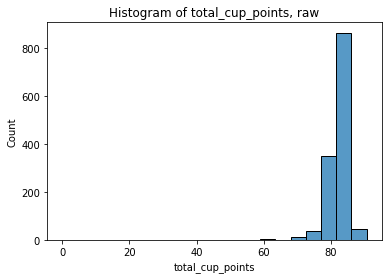

In [408]:
sns.histplot(data=df, x='total_cup_points', bins=20)
plt.title('Histogram of total_cup_points, raw')
plt.show()

Histogram shows presense of outlier(s) where `total_cup_points` is zero

In [409]:
# Entries where total_cup_points < 73 
outliers = df['total_cup_points'] < 73 
noutliers = outliers.sum()
print("{} entries will be removed, where total_cup_points is less than 73".format(noutliers))
print("This is {:.1f}% of the data".format(100*noutliers/df.shape[0]))

17 entries will be removed, where total_cup_points is less than 73
This is 1.3% of the data


In [410]:
# remove outlier of zero cupping score
df = df[(df['total_cup_points'] >= 73)]

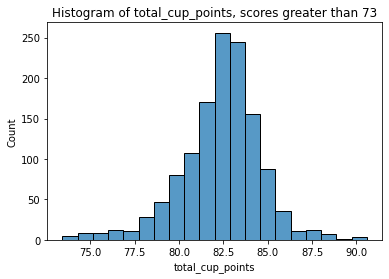

In [411]:
sns.histplot(data=df, x='total_cup_points', bins=20)
plt.title('Histogram of total_cup_points, scores greater than 73')
plt.show()

### Check for multicolinearity in cupping scores

From my previous knowledge as a coffee professional, I know that the variable `total_cup_points` is a sum of other cupping scores, `aroma`, `aftertaste`, `acidity`, `body`, `balance`, `uniformity`, `clean_cup`, `sweetness`, and `cupper_points`. Let's verify this.

In [412]:
cupping_columns = ["aroma", "flavor", "aftertaste", "acidity", "body", "balance", "uniformity", "clean_cup", "sweetness", "cupper_points"]

In [413]:
# Is total_cup_points a linear combination of other columns?
df['sum_cup_points'] = df['aroma'] + df['flavor'] + df['aftertaste'] + df['acidity'] + df['body'] + df['balance'] + df['uniformity'] + df['clean_cup'] + df['sweetness'] + df['cupper_points']

In [414]:
df.corr().loc[:,'total_cup_points'].sort_values(ascending=False)[:12]

total_cup_points    1.000000
sum_cup_points      0.999974
flavor              0.856841
aftertaste          0.847599
balance             0.776201
cupper_points       0.772892
acidity             0.732923
aroma               0.724454
body                0.672605
clean_cup           0.437526
uniformity          0.414951
sweetness           0.243898
Name: total_cup_points, dtype: float64

`total_cup_points` is very highly correlated with `sum_cup_points` and the individual cupping scores

In [415]:
df.loc[:,['sum_cup_points', 'total_cup_points']]

,sum_cup_points,total_cup_points
1,90.59,90.58
2,89.92,89.92
3,89.76,89.75
4,89.01,89.00
5,88.83,88.83
...,...,...
1290,74.01,74.00
1291,73.83,73.83
1292,73.68,73.67
1293,73.50,73.50


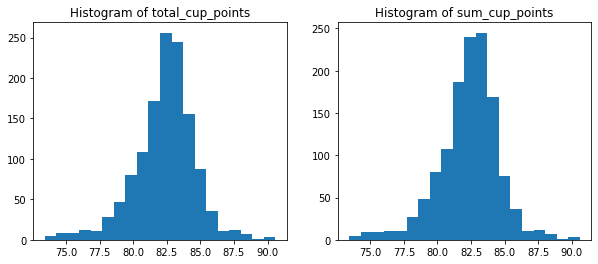

In [416]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['total_cup_points'], bins=20)
plt.title("Histogram of total_cup_points")
plt.subplot(1, 2, 2)
plt.hist(df['sum_cup_points'], bins=20)
plt.title("Histogram of sum_cup_points")
plt.show()

As expected, total_cup_points is the sum of the other cupping points columns. I will remove these columns to eliminate multicolinearity in our model

In [417]:
df = df.drop(['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points', 'sum_cup_points'], axis=1)

### Look for meaningful features

#### Numeric Columns

In [418]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns

In [419]:
numeric_columns

Index(['total_cup_points', 'altitude_low_meters', 'altitude_high_meters',
       'altitude_mean_meters', 'number_of_bags', 'moisture',
       'category_one_defects', 'quakers', 'category_two_defects'],
      dtype='object')

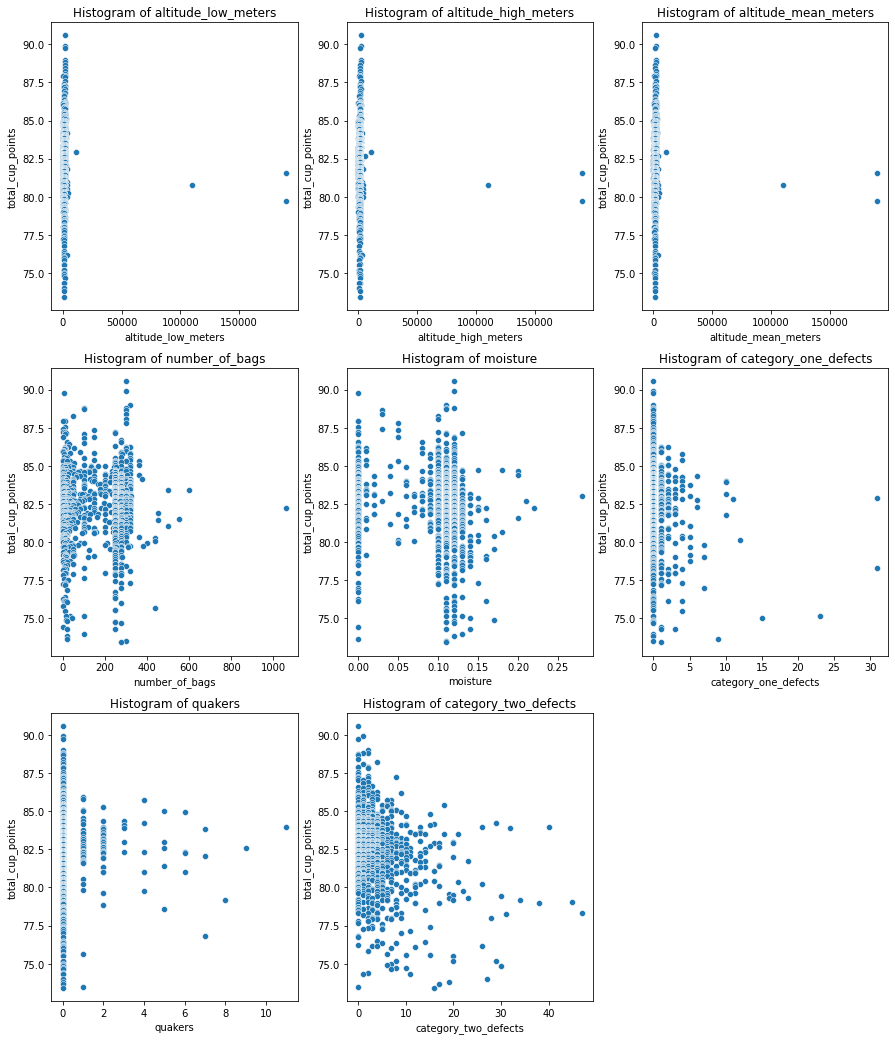

In [420]:
plot_numeric_columns = numeric_columns[1:,] #do not include total_cup_points

plt.figure(figsize = (15,18))

for i, col in enumerate(plot_numeric_columns):
  plt.subplot(3, 3, i+1)
  sns.scatterplot(data=df, x=col, y='total_cup_points')
  plt.title("Histogram of {}".format(col))
plt.show()

- Clear outliers in altitude, moisture, defects, number_of_bags

#### Non numeric columns

In [421]:
non_numeric_columns = df.select_dtypes(['object']).columns

In [422]:
non_numeric_columns

Index(['country_of_origin', 'in_country_partner', 'certification_body',
       'variety', 'processing_method', 'altitude', 'species', 'owner',
       'farm_name', 'lot_number', 'mill', 'ico_number', 'company', 'region',
       'producer', 'bag_weight', 'harvest_year', 'grading_date', 'owner_1',
       'color', 'expiration', 'certification_address', 'certification_contact',
       'unit_of_measurement'],
      dtype='object')

In [423]:
#number of categories in each
for col in non_numeric_columns:
  print(col)
  print(df[col].nunique())

country_of_origin
36
in_country_partner
27
certification_body
26
variety
29
processing_method
5
altitude
380
species
1
owner
302
farm_name
552
lot_number
219
mill
440
ico_number
833
company
267
region
337
producer
670
bag_weight
55
harvest_year
46
grading_date
558
owner_1
306
color
4
expiration
557
certification_address
30
certification_contact
27
unit_of_measurement
2


Explaination for dropping features
- Including categorical features with many unique values increases the number of dummy variables needed for linear regression dramatically, potentially making the model very computuationally intensive with little more explaination of the variance in our target.
  - `owner`
    - over 300 unique values
  - `farm_name` 
    - over 500 unique values
  - `lot_number`        
    - 79% missing values
  - `mill`
    - 24% missing values
    - over 400 unique values
  - `ico_number`
    - over 800 unique values
  - `company`
    - over 250 unique values
  - `producer`
    - over 600 unique values
  - `certification_contract`
    - over 30 unique long strings
  - `certification_address`
    - over 30 unique long strings
  - owner_1
    - over 300 unique values
- `altitude` 
  - cleaner alitude columns with same data in `low_altitude_meters`, `alitutde_high_meters`, and `altitude_mean_meters`
- `species`
  - only one unique value, arabica


In [424]:
df = df.drop(['altitude', 'owner', 'farm_name', 'lot_number', 'mill', 'ico_number', 'company', 'producer', 'certification_address', 'certification_contact', 'species', 'owner_1'], axis=1)

In [425]:
df.head(15)

,total_cup_points,country_of_origin,in_country_partner,certification_body,variety,processing_method,altitude_low_meters,altitude_high_meters,altitude_mean_meters,region,number_of_bags,bag_weight,harvest_year,grading_date,moisture,category_one_defects,quakers,color,category_two_defects,expiration,unit_of_measurement
1,90.58,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,NaN,Washed / Wet,1950.0,2200.0,2075.0,guji-hambela,300,60 kg,2014,"April 4th, 2015",0.12,0,0.0,Green,0,"April 3rd, 2016",m
2,89.92,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,Other,Washed / Wet,1950.0,2200.0,2075.0,guji-hambela,300,60 kg,2014,"April 4th, 2015",0.12,0,0.0,Green,1,"April 3rd, 2016",m
3,89.75,Guatemala,Specialty Coffee Association,Specialty Coffee Association,Bourbon,NaN,1600.0,1800.0,1700.0,NaN,5,1,NaN,"May 31st, 2010",0.00,0,0.0,NaN,0,"May 31st, 2011",m
4,89.00,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,NaN,Natural / Dry,1800.0,2200.0,2000.0,oromia,320,60 kg,2014,"March 26th, 2015",0.11,0,0.0,Green,2,"March 25th, 2016",m
5,88.83,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,Other,Washed / Wet,1950.0,2200.0,2075.0,guji-hambela,300,60 kg,2014,"April 4th, 2015",0.12,0,0.0,Green,2,"April 3rd, 2016",m
6,88.83,Brazil,Specialty Coffee Institute of Asia,Specialty Coffee Institute of Asia,NaN,Natural / Dry,NaN,NaN,NaN,NaN,100,30 kg,2013,"September 3rd, 2013",0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",m
7,88.75,Peru,Specialty Coffee Institute of Asia,Specialty Coffee Institute of Asia,Other,Washed / Wet,NaN,NaN,NaN,NaN,100,69 kg,2012,"September 17th, 2012",0.11,0,0.0,Bluish-Green,0,"September 17th, 2013",m
8,88.67,Ethiopia,Ethiopia Commodity Exchange,Ethiopia Commodity Exchange,NaN,NaN,1570.0,1700.0,1635.0,oromia,300,60 kg,March 2010,"September 2nd, 2010",0.03,0,0.0,NaN,0,"September 2nd, 2011",m
9,88.42,Ethiopia,Ethiopia Commodity Exchange,Ethiopia Commodity Exchange,NaN,NaN,1570.0,1700.0,1635.0,oromiya,300,60 kg,March 2010,"September 2nd, 2010",0.03,0,0.0,NaN,0,"September 2nd, 2011",m
10,88.25,Ethiopia,METAD Agricultural Development plc,METAD Agricultural Development plc,Other,Natural / Dry,1795.0,1850.0,1822.5,"snnp/kaffa zone,gimbowereda",50,60 kg,2014,"March 30th, 2015",0.10,0,0.0,Green,4,"March 29th, 2016",m


##### Country of Origin

In [426]:
grp = df.groupby('country_of_origin')

In [427]:
# top 10 countries
grp.size().sort_values(ascending=False)[0:9]

country_of_origin
Mexico                    231
Colombia                  182
Guatemala                 180
Brazil                    131
Taiwan                     75
United States (Hawaii)     72
Costa Rica                 50
Honduras                   49
Ethiopia                   44
dtype: int64

In [428]:
countries = ['Mexico', 'Colombia', 'Guatemala', 'Brazil', 'Taiwan', 'United States (Hawaii)', 'Honduras', 'Costa Rica', 'Ethiopia']

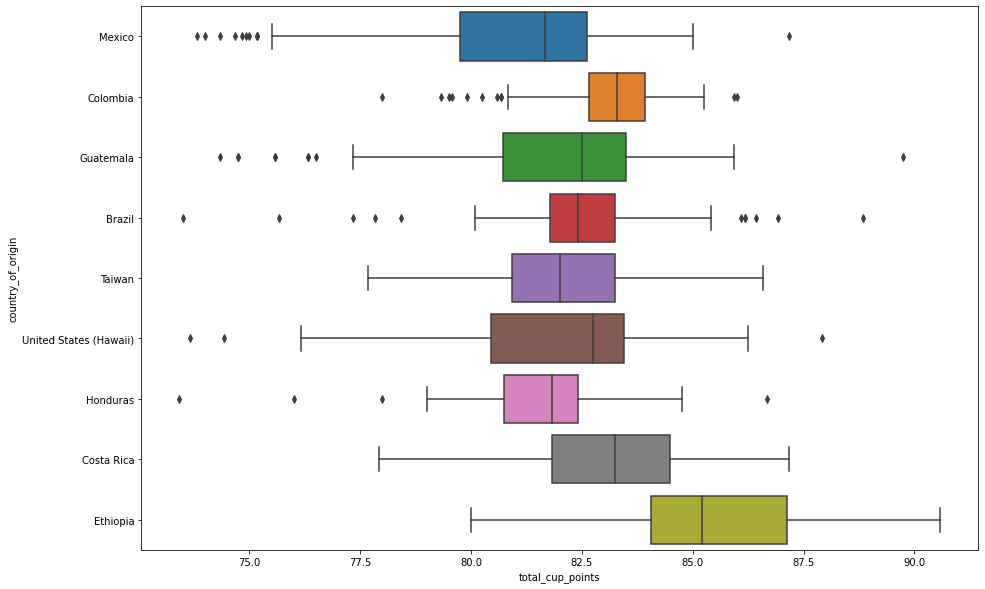

In [429]:
plt.figure(figsize=(15,10))
sns.boxplot(y="country_of_origin", x="total_cup_points", order=countries, orient ='h', data=df)
plt.show()

##### in_country_partner and country_of_origin similarities

In [430]:
#clean typos
df['in_country_partner'].replace({'Specialty Coffee Ass':'Specialty Coffee Association',
                                  'Blossom Valley International\n':'Blossom Valley International'}, inplace=True)

In [431]:
df.groupby('in_country_partner').size().sort_values(ascending=False)

in_country_partner
Specialty Coffee Association                                                             290
AMECAFE                                                                                  202
Almacafé                                                                                 178
Asociacion Nacional Del Café                                                             154
Brazil Specialty Coffee Association                                                       66
Blossom Valley International                                                              59
Instituto Hondureño del Café                                                              55
Africa Fine Coffee Association                                                            49
Specialty Coffee Association of Costa Rica                                                41
NUCOFFEE                                                                                  36
Kenya Coffee Traders Association                   

In [432]:
df[['country_of_origin','in_country_partner']].head(20)

,country_of_origin,in_country_partner
1,Ethiopia,METAD Agricultural Development plc
2,Ethiopia,METAD Agricultural Development plc
3,Guatemala,Specialty Coffee Association
4,Ethiopia,METAD Agricultural Development plc
5,Ethiopia,METAD Agricultural Development plc
6,Brazil,Specialty Coffee Institute of Asia
7,Peru,Specialty Coffee Institute of Asia
8,Ethiopia,Ethiopia Commodity Exchange
9,Ethiopia,Ethiopia Commodity Exchange
10,Ethiopia,METAD Agricultural Development plc


- I have concerns of mulitcolinearity between `country_of_origin` and `in_country_partner`. Many partner names seem to relate to the country of origin. I will concentrate on `country_of_origin` for this analysis 

##### certification_body and in_country partner similarities


In [433]:
df['certification_body'].nunique()

26

In [434]:
df['in_country_partner'].nunique()

25

In [435]:
df.groupby('certification_body').size().sort_values(ascending=False)

certification_body
Specialty Coffee Association                                                             289
AMECAFE                                                                                  202
Almacafé                                                                                 178
Asociacion Nacional Del Café                                                             154
Brazil Specialty Coffee Association                                                       66
Blossom Valley International                                                              58
Instituto Hondureño del Café                                                              55
Africa Fine Coffee Association                                                            49
Specialty Coffee Association of Costa Rica                                                42
NUCOFFEE                                                                                  36
Uganda Coffee Development Authority                

In [436]:
df.groupby('in_country_partner').size().sort_values(ascending=False)

in_country_partner
Specialty Coffee Association                                                             290
AMECAFE                                                                                  202
Almacafé                                                                                 178
Asociacion Nacional Del Café                                                             154
Brazil Specialty Coffee Association                                                       66
Blossom Valley International                                                              59
Instituto Hondureño del Café                                                              55
Africa Fine Coffee Association                                                            49
Specialty Coffee Association of Costa Rica                                                41
NUCOFFEE                                                                                  36
Kenya Coffee Traders Association                   

`certification_body` and `in_country_partner` are very similar. Both will not be considered in modeling because I believe `country_of_origin` will capture most of the potential information, or variance, for `total_cup_points`.

## Data Cleaning

### total and percent missing for each feature

In [437]:
total_missing = df.isnull().sum()

In [438]:
total_missing

total_cup_points          0
country_of_origin         1
in_country_partner        0
certification_body        0
variety                 198
processing_method       150
altitude_low_meters     224
altitude_high_meters    224
altitude_mean_meters    224
region                   56
number_of_bags            0
bag_weight                0
harvest_year             47
grading_date              0
moisture                  0
category_one_defects      0
quakers                   1
color                   214
category_two_defects      0
expiration                0
unit_of_measurement       0
dtype: int64

In [439]:
percent_missing = round((df.isnull().sum()/df.isnull().count()),2)*100

In [440]:
percent_missing

total_cup_points         0.0
country_of_origin        0.0
in_country_partner       0.0
certification_body       0.0
variety                 15.0
processing_method       12.0
altitude_low_meters     17.0
altitude_high_meters    17.0
altitude_mean_meters    17.0
region                   4.0
number_of_bags           0.0
bag_weight               0.0
harvest_year             4.0
grading_date             0.0
moisture                 0.0
category_one_defects     0.0
quakers                  0.0
color                   17.0
category_two_defects     0.0
expiration               0.0
unit_of_measurement      0.0
dtype: float64

### outliers, altitude

In [441]:
df.loc[:,['altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']].head(20)

,altitude_low_meters,altitude_high_meters,altitude_mean_meters
1,1950.0,2200.0,2075.0
2,1950.0,2200.0,2075.0
3,1600.0,1800.0,1700.0
4,1800.0,2200.0,2000.0
5,1950.0,2200.0,2075.0
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,1570.0,1700.0,1635.0
9,1570.0,1700.0,1635.0
10,1795.0,1850.0,1822.5


`altitude_mean_meters` is the average of `altitude_low_meters` and `altitude_high_meters`

In [442]:
plot_altitude_columns = df.loc[:,['altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']]

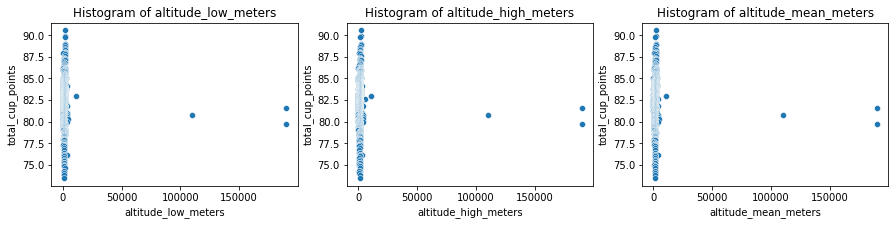

In [443]:
plt.figure(figsize = (15,3))

for i, col in enumerate(plot_altitude_columns):
  plt.subplot(1, 3, i+1)
  sns.scatterplot(data=df, x=col, y='total_cup_points')
  plt.title("Histogram of {}".format(col))
plt.show()

- Mount Everest is [8,849 meters](https://www.britannica.com/place/Mount-Everest) high. 
- Altitudes above [5,000 meters](https://en.wikipedia.org/wiki/List_of_mountains_by_elevation#5,000_metres) are mountains, unlikely to be a reasonable altitude for coffee production.
- High altitude coffees are defined at about [1500 meters](https://caffenero.com/us/the-journal/how-altitude-affects-the-taste-of-coffee/) above sea level. 
  - commonly from Ethiopia, Kenya, and Colombia
- I will replace any altitude above **2000 meters** with a missing value. 

In [444]:
n_high_outliers = (df['altitude_mean_meters'] > 2000).sum()

In [445]:
print('The number of high outliers for altitutde is {}'.format(n_high_outliers))

The number of high outliers for altitutde is 28


In [446]:
percent_high_outliers = (n_high_outliers / df.shape[0])

In [447]:
print('The percent of high outliers for altitude is {}'.format(round(percent_high_outliers,3)))

The percent of high outliers for altitude is 0.022


In [448]:
#replace outliers with missing values
df['altitude_mean_meters'] = np.where(df['altitude_mean_meters']>=2000, np.nan, df['altitude_mean_meters'])


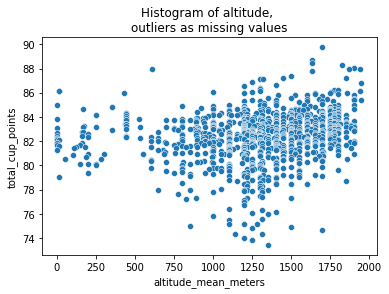

In [449]:
sns.scatterplot(data=df, x='altitude_mean_meters', y='total_cup_points')
plt.title("Histogram of altitude, \noutliers as missing values")
plt.show()

### missing values, altitude

In [450]:
altitude_n_missing = df['altitude_mean_meters'].isnull().sum()
print('The number of missing values for altitude is {}'.format(altitude_n_missing))

The number of missing values for altitude is 256


In [451]:
altitude_percent_missing = altitude_n_missing / df.shape[0]
print('The percent of missing values for altitude is {}'.format(round(altitude_percent_missing,3)))

The percent of missing values for altitude is 0.198


About 20% of the altitude feature are missing values. I beleive this will be a key feature for estimating `total_cup_scores`, so I will exercise caution with how to replace them.

In [452]:
#number of missing values in altitude_mean_meters by country 
print('Number of missing values by country')
df.groupby('country_of_origin')['altitude_mean_meters'].count().rsub(df.groupby('country_of_origin').size()).sort_values(ascending=False)


Number of missing values by country


country_of_origin
United States (Hawaii)          70
Colombia                        38
Guatemala                       31
Brazil                          27
Ethiopia                        19
Thailand                        12
Nicaragua                        9
Peru                             8
Myanmar                          5
Taiwan                           5
Costa Rica                       5
Mexico                           4
Tanzania, United Republic Of     4
Kenya                            4
Indonesia                        3
United States                    3
Uganda                           2
Honduras                         2
El Salvador                      2
India                            1
Malawi                           1
Japan                            0
Laos                             0
Vietnam                          0
Mauritius                        0
Haiti                            0
Panama                           0
Papua New Guinea                 0
Ph

In [453]:
#countries = ['United States (Hawaii)', 'Colombia', 'Brazil', 'Guatemala', 'Ethiopia', 'Thailand', 'Nicaragua','Peru','Costa Rica', 'Peru', 'Mexico', 'Tanzania, United Republic Of', 'Indonesia']
countries = ['Mexico', 'Colombia', 'Ethiopia']

In [454]:
print('percent missing by country')
for country in countries:
  print(country)
  print(round((df[df['country_of_origin'] == country]['altitude_mean_meters'].isna().sum()) / ((df[df['country_of_origin'] == country]['altitude_mean_meters'].isna().sum()
) + (df[df['country_of_origin'] == country]['altitude_mean_meters'].count())),3))


percent missing by country
Mexico
0.017
Colombia
0.209
Ethiopia
0.432


In [455]:
df2 = df.copy()

In [456]:
# fill missing values with mean
for country in countries:
  df2.loc[df2['country_of_origin'] == country, 'altitude_mean_meters'] = df2.loc[df['country_of_origin'] == country, 'altitude_mean_meters'].fillna(df2[
  df2['country_of_origin'] == country]['altitude_mean_meters'].mean())

In [457]:
df3 = df.copy()

In [458]:
# fill missing values with median
for country in countries:
  df3.loc[df3['country_of_origin'] == country, 'altitude_mean_meters'] = df3.loc[df['country_of_origin'] == country, 'altitude_mean_meters'].fillna(df3[
  df3['country_of_origin'] == country]['altitude_mean_meters'].median())

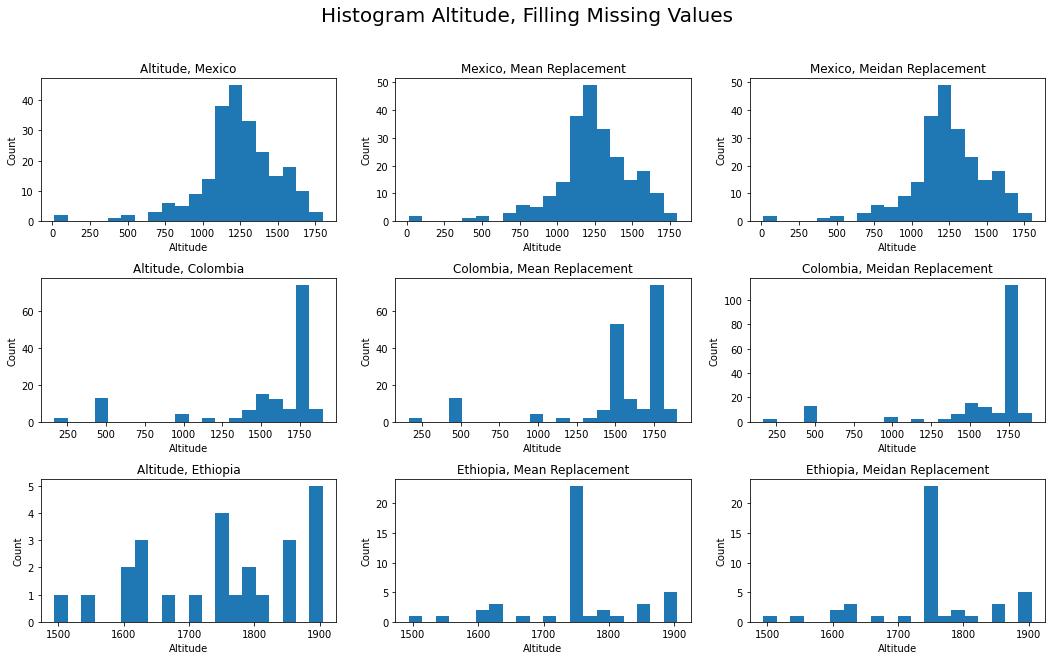

In [459]:
plt.figure(figsize=(18,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
plt.suptitle('Histogram Altitude, Filling Missing Values', fontsize=20)

for i, country in enumerate(countries):
  plt.subplot(len(countries), 3, (i*3)+1)
  plt.hist(df[df['country_of_origin'] == country]['altitude_mean_meters'], bins=20)
  plt.title("Altitude, {}".format(country))
  plt.xlabel('Altitude')
  plt.ylabel('Count')
  plt.subplot(len(countries), 3, (i*3)+2)
  plt.hist(df2[df2['country_of_origin'] == country]['altitude_mean_meters'], bins=20)
  plt.title("{}, Mean Replacement".format(country))
  plt.xlabel('Altitude')
  plt.ylabel('Count')
  plt.subplot(len(countries), 3, (i*3)+3)
  plt.hist(df3[df3['country_of_origin'] == country]['altitude_mean_meters'], bins=20)
  plt.title("{}, Meidan Replacement".format(country))
  plt.xlabel('Altitude')
  plt.ylabel('Count')
plt.show()  
#plt.savefig('altitude_hists.png')
#files.download("altitude_hists.png") 

Choosing the Median for central tendency

In [460]:
countries = df['country_of_origin'].unique()

In [461]:
countries

array(['Ethiopia', 'Guatemala', 'Brazil', 'Peru', 'United States',
       'United States (Hawaii)', 'Indonesia', 'China', 'Costa Rica',
       'Mexico', 'Uganda', 'Honduras', 'Taiwan', 'Nicaragua',
       'Tanzania, United Republic Of', 'Kenya', 'Thailand', 'Colombia',
       'Panama', 'Papua New Guinea', 'El Salvador', 'Japan', 'Ecuador',
       'United States (Puerto Rico)', 'Haiti', 'Burundi', 'Vietnam',
       'Philippines', 'Rwanda', 'Malawi', 'Laos', 'Zambia', 'Myanmar',
       'Mauritius', 'Cote d?Ivoire', nan, 'India'], dtype=object)

In [462]:
# fill missing values with median

for country in countries:
  df.loc[df['country_of_origin'] == country, 'altitude_mean_meters'] = df.loc[df['country_of_origin'] == country, 'altitude_mean_meters'].fillna(df[
  df['country_of_origin'] == country]['altitude_mean_meters'].median())

### missing values, processing method

In [463]:
df['processing_method'].unique()

array(['Washed / Wet', nan, 'Natural / Dry', 'Pulped natural / honey',
       'Semi-washed / Semi-pulped', 'Other'], dtype=object)

In [464]:
df.groupby('processing_method').size()

processing_method
Natural / Dry                247
Other                         25
Pulped natural / honey        14
Semi-washed / Semi-pulped     56
Washed / Wet                 802
dtype: int64

In [465]:
# percent missing for processing method
round(df['processing_method'].isna().sum() / df['processing_method'].isna().count(),3)

0.116

In [466]:
#remove Côte d'Ivoire and India, no other coffees in this region, most of data missing
df = df.loc[df['country_of_origin'] != 'Cote d?Ivoire']
df = df.loc[df['country_of_origin'] != 'India']

In [467]:
countries = df['country_of_origin'].unique()[:-1]

In [468]:
#percent missing for each country
for country in countries:
  print(country)
  print(round(df[df['country_of_origin'] == country]['processing_method'].isna().sum() / df[df['country_of_origin'] == country]['processing_method'].isna().count(),3))

Ethiopia
0.432
Guatemala
0.044
Brazil
0.107
Peru
0.2
United States
0.0
United States (Hawaii)
0.333
Indonesia
0.15
China
0.0
Costa Rica
0.04
Mexico
0.03
Uganda
0.0
Honduras
0.061
Taiwan
0.067
Nicaragua
0.32
Tanzania, United Republic Of
0.025
Kenya
0.04
Thailand
0.344
Colombia
0.192
Panama
0.0
Papua New Guinea
0.0
El Salvador
0.19
Japan
0.0
Ecuador
0.0
United States (Puerto Rico)
0.0
Haiti
0.0
Burundi
0.5
Vietnam
0.0
Philippines
0.0
Rwanda
0.0
Malawi
0.0
Laos
0.0
Zambia
0.0
Myanmar
0.0
Mauritius
1.0


In [469]:
#exception, Mauritius, only missing values for processing_method, used overall mode to fill missing value
df.loc[df['country_of_origin'] == 'Mauritius','processing_method'] = df.loc[df['country_of_origin'] == 'Mauritius','processing_method'].fillna(df['processing_method'].mode()[0]) 

In [470]:
#mode for each country
for country in countries:
  print(country)
  print(df[df['country_of_origin'] == country]['processing_method'].mode()[0])

Ethiopia
Natural / Dry
Guatemala
Washed / Wet
Brazil
Natural / Dry
Peru
Washed / Wet
United States
Washed / Wet
United States (Hawaii)
Natural / Dry
Indonesia
Washed / Wet
China
Washed / Wet
Costa Rica
Washed / Wet
Mexico
Washed / Wet
Uganda
Washed / Wet
Honduras
Washed / Wet
Taiwan
Washed / Wet
Nicaragua
Washed / Wet
Tanzania, United Republic Of
Washed / Wet
Kenya
Washed / Wet
Thailand
Washed / Wet
Colombia
Washed / Wet
Panama
Washed / Wet
Papua New Guinea
Washed / Wet
El Salvador
Washed / Wet
Japan
Pulped natural / honey
Ecuador
Natural / Dry
United States (Puerto Rico)
Washed / Wet
Haiti
Washed / Wet
Burundi
Washed / Wet
Vietnam
Natural / Dry
Philippines
Washed / Wet
Rwanda
Washed / Wet
Malawi
Washed / Wet
Laos
Washed / Wet
Zambia
Washed / Wet
Myanmar
Washed / Wet
Mauritius
Washed / Wet


In [471]:
#replace missing categories by mode by country
for country in countries:
  df.loc[df['country_of_origin'] == country, 'processing_method'] = df.loc[df['country_of_origin'] == country, 'processing_method'].fillna(df[
  df['country_of_origin'] == country]['processing_method'].mode()[0])

### missing values, color

In [472]:
df['color'].unique()

array(['Green', nan, 'Bluish-Green', 'None', 'Blue-Green'], dtype=object)

In [473]:
df['color'] = df['color'].replace('None', np.nan)

In [474]:
#percent missing color 
round(df['color'].isna().sum() / df['color'].isna().count(),3)

0.204

In [475]:
countries = df['country_of_origin'].unique()[:-1]

In [476]:
#percent missing for each country
for country in countries:
  print(country)
  print(round(df[df['country_of_origin'] == country]['color'].isna().sum() / df[df['country_of_origin'] == country]['color'].isna().count(),3))

Ethiopia
0.614
Guatemala
0.072
Brazil
0.107
Peru
0.2
United States
1.0
United States (Hawaii)
0.417
Indonesia
0.35
China
0.0
Costa Rica
0.08
Mexico
0.277
Uganda
0.038
Honduras
0.02
Taiwan
0.08
Nicaragua
0.2
Tanzania, United Republic Of
0.025
Kenya
0.08
Thailand
0.375
Colombia
0.269
Panama
0.25
Papua New Guinea
0.0
El Salvador
0.381
Japan
0.0
Ecuador
0.0
United States (Puerto Rico)
0.0
Haiti
0.25
Burundi
0.5
Vietnam
0.429
Philippines
0.2
Rwanda
0.0
Malawi
0.0
Laos
0.0
Zambia
1.0
Myanmar
0.125
Mauritius
0.0


In [477]:
#exception, United States, only missing values for color, used the mode of Mexico to fill missing value
df.loc[df['country_of_origin'] == 'United States','color'] = df.loc[df['country_of_origin'] == 'United States','color'].fillna(df[df['country_of_origin'] == 'Mexico']['color'].mode()[0]) 

In [478]:
#exception, Zambia
df.loc[df['country_of_origin'] == 'Zambia','color'] = df.loc[df['country_of_origin'] == 'Zambia','color'].fillna(df['color'].mode()[0])

In [479]:
#mode for each country
for country in countries:
  print(country)
  print(df[df['country_of_origin'] == country]['color'].mode()[0])

Ethiopia
Green
Guatemala
Green
Brazil
Green
Peru
Green
United States
Green
United States (Hawaii)
Green
Indonesia
Green
China
Green
Costa Rica
Green
Mexico
Green
Uganda
Green
Honduras
Green
Taiwan
Green
Nicaragua
Green
Tanzania, United Republic Of
Green
Kenya
Green
Thailand
Green
Colombia
Green
Panama
Green
Papua New Guinea
Bluish-Green
El Salvador
Green
Japan
Green
Ecuador
Bluish-Green
United States (Puerto Rico)
Green
Haiti
Green
Burundi
Green
Vietnam
Green
Philippines
Green
Rwanda
Bluish-Green
Malawi
Green
Laos
Blue-Green
Zambia
Green
Myanmar
Green
Mauritius
Green


In [480]:
#replace missing categories by mode by country

for country in countries:
  df.loc[df['country_of_origin'] == country, 'color'] = df.loc[df['country_of_origin'] == country, 'color'].fillna(df[
  df['country_of_origin'] == country]['color'].mode()[0])

### missing values and outliers, moisture

In [481]:
df[df['moisture'] == 0]['moisture'].count()

print('The number of moisture values that are equal to zero is {}'.format(df[df['moisture'] == 0]['moisture'].count()))
print('That is {0:.2f} portion of the data'.format(df[df['moisture'] == 0]['moisture'].count() / len(df['moisture'])
))

The number of moisture values that are equal to zero is 249
That is 0.19 portion of the data


In [482]:
small_df = df[df['moisture'] == 0]

In [483]:
# number of moisture entries coded as 0 by country
print('Number moisture equal to 0 by country')
small_df.groupby('country_of_origin')['moisture'].count().sort_values(ascending=False)


Number moisture equal to 0 by country


country_of_origin
Colombia                        76
Brazil                          31
United States (Hawaii)          27
Taiwan                          18
Mexico                          13
El Salvador                     12
Costa Rica                      11
United States                    8
Guatemala                        7
Myanmar                          7
Kenya                            6
Thailand                         6
Ethiopia                         5
Peru                             4
Vietnam                          3
Indonesia                        3
Philippines                      2
United States (Puerto Rico)      2
China                            2
Panama                           1
Laos                             1
Tanzania, United Republic Of     1
Uganda                           1
Burundi                          1
Zambia                           1
Name: moisture, dtype: int64

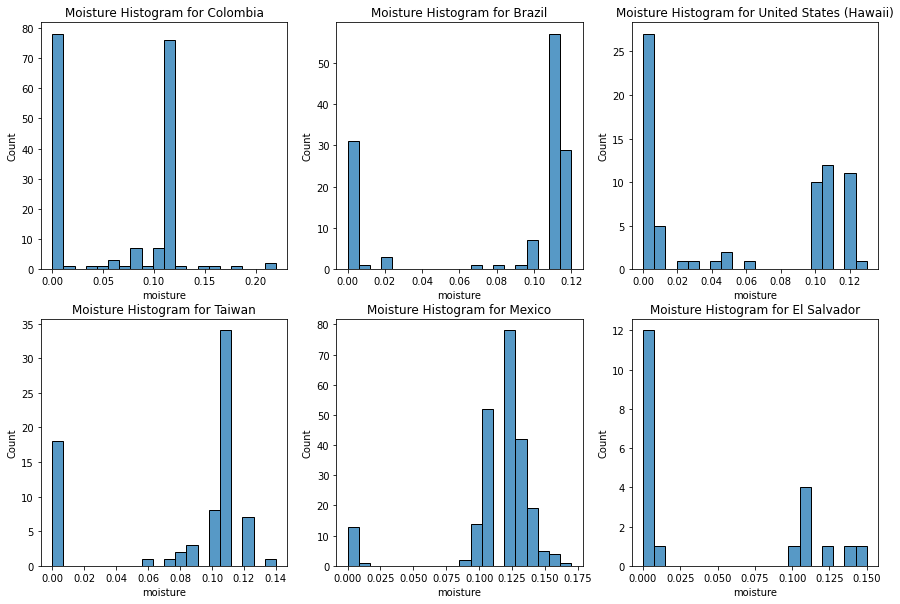

In [484]:
plt_countries = ['Colombia', 'Brazil', 'United States (Hawaii)', 'Taiwan', 'Mexico', 'El Salvador']

plt.figure(figsize = (15,10))

for i, country in enumerate(plt_countries):
  plt.subplot(2, 3, i+1)
  sns.histplot(data=df[df['country_of_origin'] == country], x='moisture', bins=20)
  plt.title("Moisture Histogram for {}".format(country))
plt.show()

In [485]:
countries = df['country_of_origin'].unique()

In [486]:
#replace with mean by country

for country in countries:
  df.loc[df['country_of_origin'] == country, 'moisture'] = df.loc[df['country_of_origin'] == country, 'moisture'].replace(0,df[df['country_of_origin'] == country]['moisture'].mean())

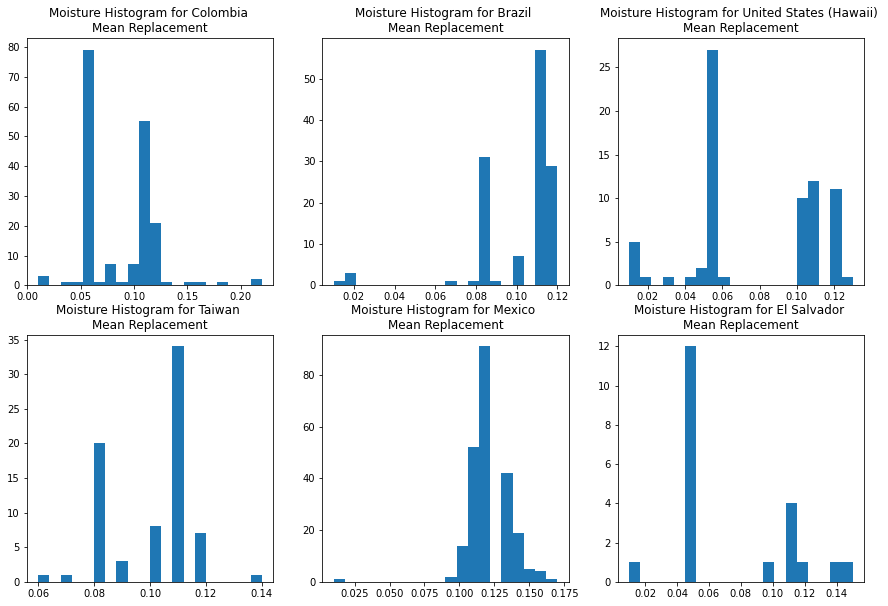

In [487]:
plt_countries = ['Colombia', 'Brazil', 'United States (Hawaii)', 'Taiwan', 'Mexico', 'El Salvador']

plt.figure(figsize = (15,10))

for i, country in enumerate(plt_countries):
  plt.subplot(2, 3, i+1)
  plt.hist(x=df[df['country_of_origin'] == country]['moisture'], bins=20, log=False)
  plt.title('Moisture Histogram for {} \nMean Replacement'.format(country))
plt.show()

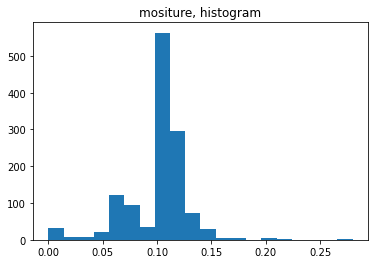

In [488]:
plt.hist(df['moisture'], bins=20)
plt.title('mositure, histogram')
plt.show()

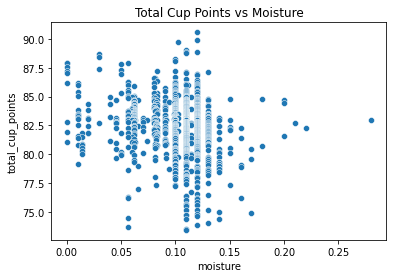

In [489]:
sns.scatterplot(data=df, x='moisture', y='total_cup_points')
plt.title('Total Cup Points vs Moisture')
plt.show()

In [490]:
df[df['moisture'] > .19]['moisture'].count()

6

In [491]:
# remove outlier in moisture feature
df = df[(df['moisture'] <= .19)]

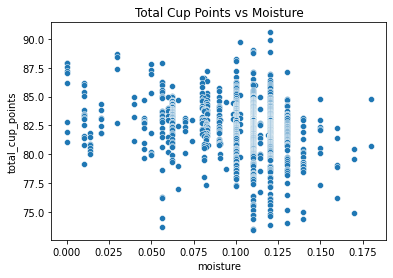

In [492]:
sns.scatterplot(data=df, x='moisture', y='total_cup_points')
plt.title('Total Cup Points vs Moisture')
plt.show()

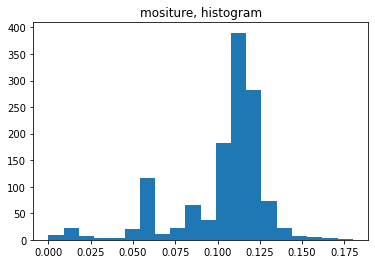

In [493]:
plt.hist(df['moisture'], bins=20)
plt.title('mositure, histogram')
plt.show()

## Feature Engineering

### myregion, feature creation

To reduce dimensionality, I will organize countries of origin into more general regions as defined below

Definition for myregion:
```
country_of_origin
Mexico                          North America
United States                   North America

Colombia                        South America
Ecuador                         South America
Brazil                          South America
Peru                            South America

Guatemala                       Central America
Honduras                        Central america
Costa Rica                      Central America
Nicaragua                       Central America
El Salvador                     Central America
Panama                          Central America

Taiwan                           Asia
China                            Asia
Japan                            Asia
Thailand                         Asia
Myanmar                          Asia
Philippines                      Asia
Vietnam                          Asia
Laos                             Asia

Ethiopia                         East Africa
Tanzania, United Republic Of     East Africa
Burundi                          East Africa
Uganda                           East Africa
Kenya                            East Africa
Malawi                           East Africa
Rwanda                           East Africa
Mauritius                        East Africa
Zambia                           East Africa

Indonesia                        Islands
Papua New Guinea                 Islands
Haiti                            Islands
United States (Puerto Rico)      Islands
United States (Hawaii)           Islands
```

In [494]:
#remove Côte d'Ivoire and India, no other coffees in this region, issues of missing data
#df = df.loc[df['country_of_origin'] != 'Cote d?Ivoire']
#df = df.loc[df['country_of_origin'] != 'India']

In [495]:
conditions = [(df['country_of_origin'] == 'Mexico') | (df['country_of_origin'] == 'United States'),
              (df['country_of_origin'] == 'Colombia') | (df['country_of_origin'] == 'Ecuador') | (df['country_of_origin'] == 'Brazil') | (df['country_of_origin'] == 'Peru'),
              (df['country_of_origin'] == 'Guatemala') | (df['country_of_origin'] == 'Honduras') | (df['country_of_origin'] == 'Costa Rica') | (df['country_of_origin'] == 'Nicaragua') | (df['country_of_origin'] == 'El Salvador') | (df['country_of_origin'] == 'Panama'),
              (df['country_of_origin'] == 'Taiwan') | (df['country_of_origin'] == 'China') | (df['country_of_origin'] == 'Japan') | (df['country_of_origin'] == 'Thailand') | (df['country_of_origin'] == 'Myanmar') | (df['country_of_origin'] == 'Philippines') | (df['country_of_origin'] == 'Vietnam') | (df['country_of_origin'] == 'Laos'),
              (df['country_of_origin'] == 'Ethiopia') | (df['country_of_origin'] == 'Tanzania, United Republic Of') | (df['country_of_origin'] == 'Burundi') | (df['country_of_origin'] == 'Uganda') | (df['country_of_origin'] == 'Kenya') | (df['country_of_origin'] == 'Malawi') | (df['country_of_origin'] == 'Rwanda') | (df['country_of_origin'] == 'Mauritius') | (df['country_of_origin'] == 'Zambia'),
              (df['country_of_origin'] == 'Indonesia') | (df['country_of_origin'] == 'Papua New Guinea') | (df['country_of_origin'] == 'Haiti') | (df['country_of_origin'] == 'United States (Puerto Rico)') | (df['country_of_origin'] == 'United States (Hawaii)')
              ]
choices = ['North America', 'South America', 'Central America', 'Asia', 'East Africa', 'Islands']

df['myregion'] = np.select(conditions, choices, default='other')

In [496]:
df[df['myregion']=='other']

,total_cup_points,country_of_origin,in_country_partner,certification_body,variety,processing_method,altitude_low_meters,altitude_high_meters,altitude_mean_meters,region,number_of_bags,bag_weight,harvest_year,grading_date,moisture,category_one_defects,quakers,color,category_two_defects,expiration,unit_of_measurement,myregion
1198,79.08,NaN,Almacafé,Almacafé,NaN,NaN,NaN,NaN,NaN,NaN,149,70 kg,NaN,"March 1st, 2011",0.1,0,0.0,NaN,3,"February 29th, 2012",m,other


In [497]:
# drop one missing value
df = df.dropna(subset=['country_of_origin'])

In [498]:
df.groupby('myregion').size().sort_values(ascending=False)

myregion
Central America    329
South America      322
North America      239
East Africa        149
Asia               145
Islands            101
dtype: int64

In [499]:
df.groupby('myregion').size().sort_values(ascending=False)

myregion
Central America    329
South America      322
North America      239
East Africa        149
Asia               145
Islands            101
dtype: int64

In [500]:
regions = ['Central America', 'South America', 'North America', 'East Africa', 'Asia', 'Islands']

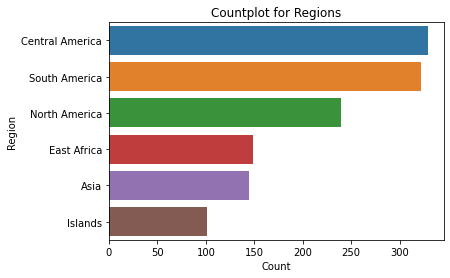

In [501]:
sns.countplot(data=df, y='myregion', orient='h', order=regions)
plt.title('Countplot for Regions')
plt.xlabel('Count')
plt.ylabel('Region')
#plt.savefig('countplot_regions.png')
#files.download("countplot_regions.png") 
plt.show()

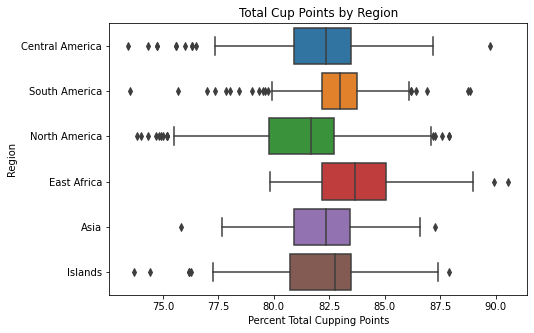

In [502]:
plt.figure(figsize=(7.5,5))
sns.boxplot(y="myregion", x="total_cup_points", data=df, orient='h', order=regions)
plt.title('Total Cup Points by Region')
plt.xlabel('Percent Total Cupping Points')
plt.ylabel('Region')
#plt.savefig('boxplot_regions.png')
#files.download("boxplot_regions.png") 
plt.show()

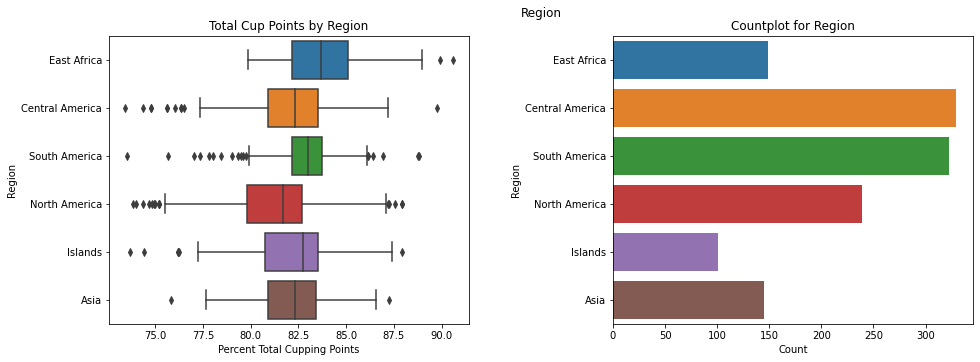

In [503]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Region')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

#boxplot
sns.boxplot(ax=axes[0], y='myregion', x='total_cup_points', data=df, orient = 'h')
axes[0].set_title('Total Cup Points by Region')
axes[0].set_xlabel('Percent Total Cupping Points')
axes[0].set_ylabel('Region')

#countplot 
sns.countplot(ax=axes[1],data=df, y='myregion')
axes[1].set_title('Countplot for Region')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Region')

#plt.savefig('region.png')
#files.download("region.png")
plt.show()

### defects: quakers, category_one_defects, category_two_defects

#### quakers

In [504]:
# 1 missing value
df['quakers'].isnull().sum()

1

In [505]:
# drop missing value
df = df.dropna(subset=['quakers'], axis=0)

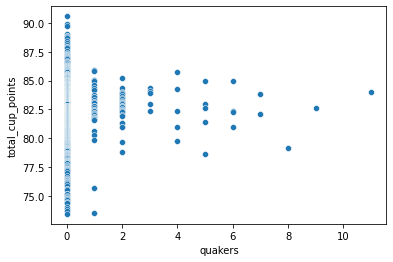

In [506]:
sns.scatterplot(x='quakers', y='total_cup_points', data=df)

In [507]:
# turn into binary variable, no presense of quakers = 0, any number of quakers = 1
df['quakers_binary'] = np.repeat(0, len(df['quakers']))

df.quakers_binary[df.quakers == 0] = 0
df.quakers_binary[df.quakers > 0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


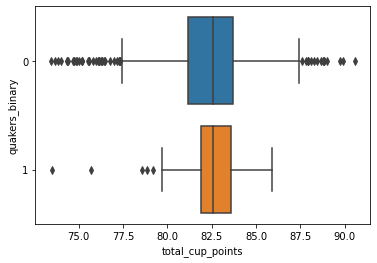

In [508]:
sns.boxplot(data=df, x='total_cup_points', y='quakers_binary', orient='h')

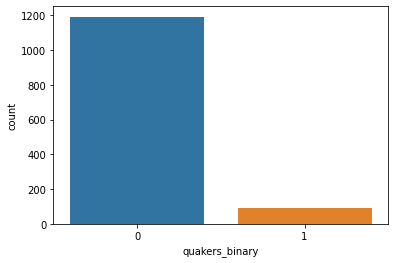

In [509]:
sns.countplot(data=df, x='quakers_binary', orient='h')

`quakers_binary` is too unbalanced to be reliable for modeling

#### category_one_defects



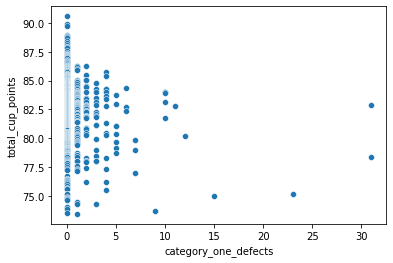

In [510]:
sns.scatterplot(data=df, y='total_cup_points', x='category_one_defects')

In [511]:
# create binary feature for category one defects
df['category_one_defects_binary'] = np.repeat(0, len(df['category_one_defects']))

df.category_one_defects_binary[df.category_one_defects == 0] = 0
df.category_one_defects_binary[df.category_one_defects > 0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


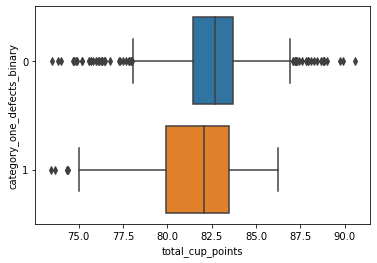

In [512]:
sns.boxplot(x='total_cup_points', y='category_one_defects_binary', data=df, orient='h')

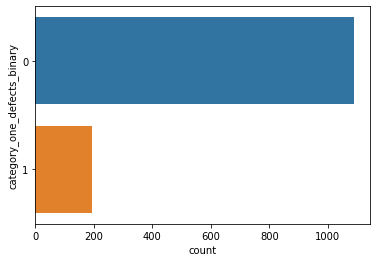

In [513]:
sns.countplot(data=df, y='category_one_defects_binary')

#### category_two_defects


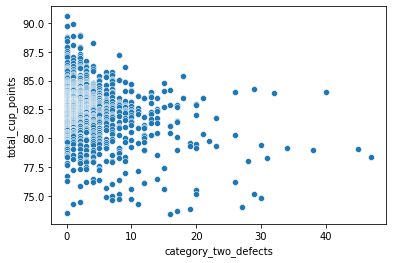

In [514]:
sns.scatterplot(data=df, y='total_cup_points', x='category_two_defects')

In [515]:
# create binary feature for category two defects
df['category_two_defects_binary'] = np.repeat(0, len(df['category_two_defects']))

df.category_two_defects_binary[df.category_two_defects == 0] = 0
df.category_two_defects_binary[df.category_two_defects > 0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


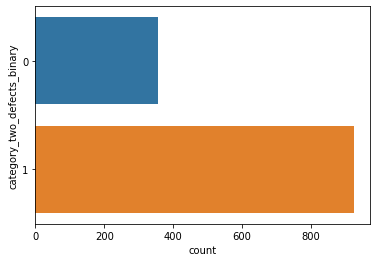

In [516]:
sns.countplot(data=df, y='category_two_defects_binary')

Category 2 defects is more balanced.  I will use this as a measure of defects.

### processing_method

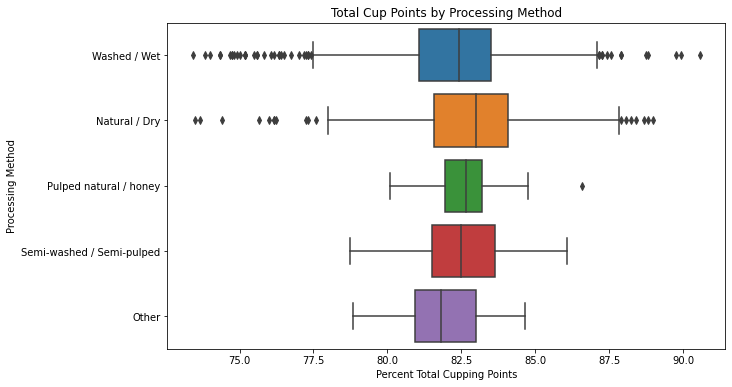

In [517]:
plt.figure(figsize=(10,6))
sns.boxplot(y='processing_method', x='total_cup_points', data=df, orient = 'h')
plt.title('Total Cup Points by Processing Method')
plt.xlabel('Percent Total Cupping Points')
plt.ylabel('Processing Method')
#plt.savefig('boxplot_processing_method.png')
#files.download("boxplot_processing_method.png")
plt.show()

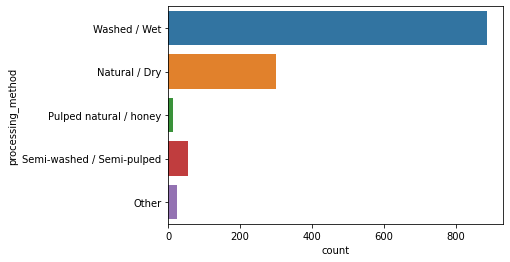

In [518]:
sns.countplot(data=df, y='processing_method')

In [519]:
#combine categories with small sample sizes
conditions = [(df['processing_method'] == 'Other') | (df['processing_method'] == 'Semi-washed / Semi-pulped') | (df['processing_method'] == 'Pulped natural / honey'),
              (df['processing_method'] == 'Natural / Dry'),
              (df['processing_method'] == 'Washed / Wet')]
choices = ['Other/Semi', 'Natural', 'Washed']
df['myprocessing_method'] = np.select(conditions, choices, default='others')

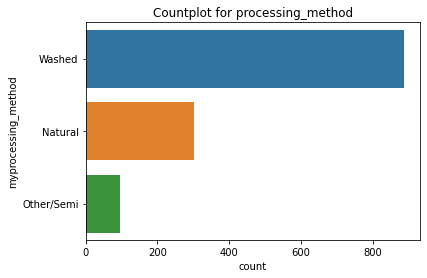

In [520]:
#more balanced 
sns.countplot(data=df, y='myprocessing_method')
plt.title('Countplot for processing_method')
#plt.savefig('countplot_processing_method.png')
#files.download("countplot_processing_method.png")
plt.show()

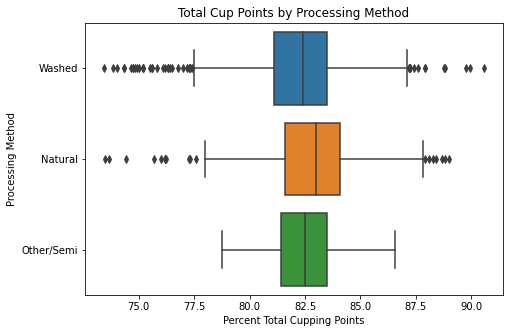

In [521]:
plt.figure(figsize=(7.5,5))
sns.boxplot(y='myprocessing_method', x='total_cup_points', data=df, orient = 'h')
plt.title('Total Cup Points by Processing Method')
plt.xlabel('Percent Total Cupping Points')
plt.ylabel('Processing Method')
#plt.savefig('boxplot_processing_method.png')
#files.download("boxplot_processing_method.png")
plt.show()

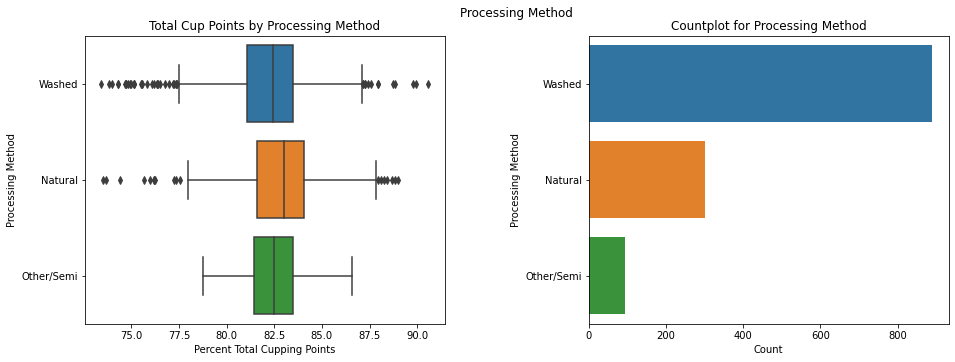

In [522]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Processing Method')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

#boxplot
sns.boxplot(ax=axes[0], y='myprocessing_method', x='total_cup_points', data=df, orient = 'h')
axes[0].set_title('Total Cup Points by Processing Method')
axes[0].set_xlabel('Percent Total Cupping Points')
axes[0].set_ylabel('Processing Method')

#countplot 
sns.countplot(ax=axes[1],data=df, y='myprocessing_method')
axes[1].set_title('Countplot for Processing Method')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Processing Method')

#plt.savefig('processing_method.png')
#files.download("processing_method.png")
plt.show()

### color

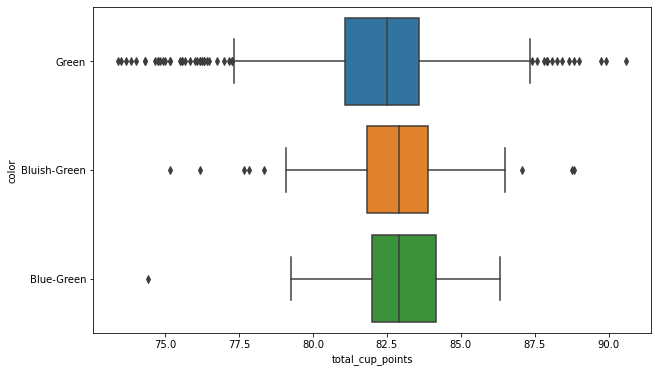

In [523]:
plt.figure(figsize=(10,6))
sns.boxplot(y='color', x='total_cup_points', data=df, orient = 'h')
plt.show()

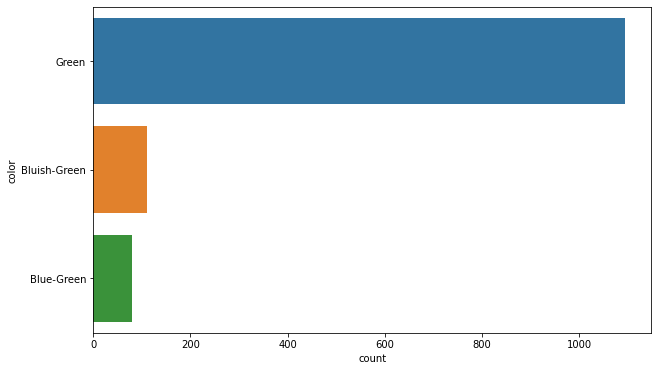

In [524]:
plt.figure(figsize=(10,6))
sns.countplot(y='color', data=df, orient = 'h')
plt.show()

### altitude

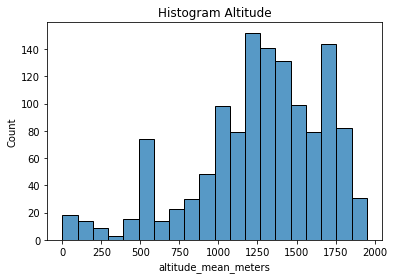

In [525]:
sns.histplot(data=df, x='altitude_mean_meters', bins=20)
plt.title('Histogram Altitude')
plt.show()

### moisture

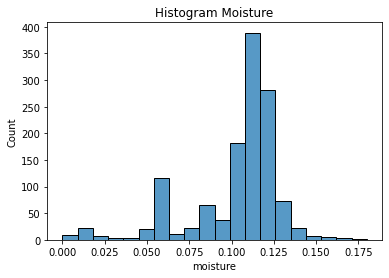

In [526]:
sns.histplot(data=df, x='moisture', bins=20)
plt.title('Histogram Moisture')
plt.show()

## Model Preparation

### standardization

In [527]:
from sklearn.preprocessing import MinMaxScaler

In [528]:
#standardize altitude and moisture columns to be between (0,1)
mms = MinMaxScaler()
df[['altitude_mean_meters','moisture']] = mms.fit_transform(df[['altitude_mean_meters', 'moisture']])

In [529]:
#standardize total_cup_points by dividing by 100 to be similar scale as features

In [530]:
#standardize total_cup_points by dividing by 100 to be similar scale as features
df.loc[:,'total_cup_points'] = df.loc[:,'total_cup_points']/100

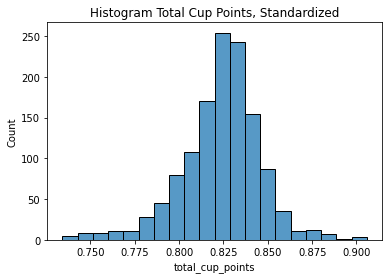

In [531]:
sns.histplot(x='total_cup_points', data=df, bins=20)
plt.title('Histogram Total Cup Points, Standardized')
plt.show()

### dropping unnecessary  features

In [532]:
# df with features of interest for modeling
df_model = df.drop(['country_of_origin', 'in_country_partner', 'certification_body', 'variety',
                    'processing_method', 'altitude_low_meters', 'altitude_high_meters', 'region',
                    'number_of_bags', 'harvest_year', 'grading_date', 'category_one_defects', 
                    'quakers', 'category_two_defects', 'expiration', 'unit_of_measurement', 
                    'quakers_binary', 'category_one_defects_binary', 'bag_weight'                        
                    ], axis=1)

In [533]:
#checking standardization for our target and numerical features to be [0,1]
df_model.describe()

,total_cup_points,altitude_mean_meters,moisture,category_two_defects_binary
count,1284.000000,1284.000000,1284.000000,1284.000000
mean,0.823395,0.647042,0.563782,0.721963
std,0.022690,0.216470,0.150191,0.448206
min,0.734200,0.000000,0.000000,0.000000
25%,0.812500,0.520267,0.555556,0.000000
50%,0.825800,0.666496,0.611111,1.000000
75%,0.836700,0.820421,0.666667,1.000000
max,0.905800,1.000000,1.000000,1.000000


In [534]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 1 to 1294
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total_cup_points             1284 non-null   float64
 1   altitude_mean_meters         1284 non-null   float64
 2   moisture                     1284 non-null   float64
 3   color                        1284 non-null   object 
 4   myregion                     1284 non-null   object 
 5   category_two_defects_binary  1284 non-null   int64  
 6   myprocessing_method          1284 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 120.2+ KB


In [535]:
# renaming columns
df_model.rename(columns={'total_cup_points': 'total_cup_points', 'altitude_mean_meters': 'altitude', 'moisture' : 'moisture', 'color' : 'color', 'myregion' : 'region', 'category_two_defects_binary' : 'defects', 'myprocessing_method' : 'processing_method'}, inplace=True)

In [536]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 1 to 1294
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_cup_points   1284 non-null   float64
 1   altitude           1284 non-null   float64
 2   moisture           1284 non-null   float64
 3   color              1284 non-null   object 
 4   region             1284 non-null   object 
 5   defects            1284 non-null   int64  
 6   processing_method  1284 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 120.2+ KB


###dummy variable creation

In [537]:
# dummy variables for: color, processing_method, myregion
df_model = pd.concat([df_model, pd.get_dummies(df_model.processing_method, prefix="processing_method", drop_first=True)], axis=1)
df_model = pd.concat([df_model, pd.get_dummies(df_model.region, prefix="region", drop_first=True)], axis=1)
df_model = pd.concat([df_model, pd.get_dummies(df_model.color, prefix="color", drop_first=True)], axis=1)
df_model = pd.concat([df_model, pd.get_dummies(df_model.defects, prefix="defects", drop_first=True)], axis=1)


In [538]:
dummy_column_names = list(pd.get_dummies(df_model.processing_method, prefix='processing', drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df_model.region, prefix="region", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df_model.color, prefix="color", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df_model.defects, prefix="defects", drop_first=True).columns)


In [539]:
df_model['region'].unique()

array(['East Africa', 'Central America', 'South America', 'North America',
       'Islands', 'Asia'], dtype=object)

In [540]:
df_model['color'].unique()

array(['Green', 'Bluish-Green', 'Blue-Green'], dtype=object)

In [541]:
df_model['processing_method'].unique()

array(['Washed', 'Natural', 'Other/Semi'], dtype=object)

In [542]:
#remove categorial features
df_model = df_model.drop(['color', 'region', 'defects', 'processing_method'], axis=1)

In [543]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 1 to 1294
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total_cup_points              1284 non-null   float64
 1   altitude                      1284 non-null   float64
 2   moisture                      1284 non-null   float64
 3   processing_method_Other/Semi  1284 non-null   uint8  
 4   processing_method_Washed      1284 non-null   uint8  
 5   region_Central America        1284 non-null   uint8  
 6   region_East Africa            1284 non-null   uint8  
 7   region_Islands                1284 non-null   uint8  
 8   region_North America          1284 non-null   uint8  
 9   region_South America          1284 non-null   uint8  
 10  color_Bluish-Green            1284 non-null   uint8  
 11  color_Green                   1284 non-null   uint8  
 12  defects_1                     1284 non-null   uint8  
dtypes: 

### split into test and train

In [544]:
X = df_model.drop('total_cup_points', axis=1)
y = df_model['total_cup_points']

In [545]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 1 to 1294
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   altitude                      1284 non-null   float64
 1   moisture                      1284 non-null   float64
 2   processing_method_Other/Semi  1284 non-null   uint8  
 3   processing_method_Washed      1284 non-null   uint8  
 4   region_Central America        1284 non-null   uint8  
 5   region_East Africa            1284 non-null   uint8  
 6   region_Islands                1284 non-null   uint8  
 7   region_North America          1284 non-null   uint8  
 8   region_South America          1284 non-null   uint8  
 9   color_Bluish-Green            1284 non-null   uint8  
 10  color_Green                   1284 non-null   uint8  
 11  defects_1                     1284 non-null   uint8  
dtypes: float64(2), uint8(10)
memory usage: 82.6 KB


In [546]:
y.describe()

count    1284.000000
mean        0.823395
std         0.022690
min         0.734200
25%         0.812500
50%         0.825800
75%         0.836700
max         0.905800
Name: total_cup_points, dtype: float64

In [547]:
from sklearn.model_selection import train_test_split

In [548]:
my_rand_state = 42

In [549]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=my_rand_state)

Since I have a smaller data set (1284), I will have my test_size to be 30% of the data

In [550]:
df_model.shape

(1284, 13)

In [551]:
X_test.shape

(386, 12)

In [552]:
X_train.shape

(898, 12)

## Modeling

### packages and functions

In [553]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
#from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import GridSearchCV, cross_val_score

In [554]:
my_rand_state = 42

In [555]:
def test_stats(y_test, predictions):
  print('rmse: {:f}'.format(sqrt(mean_squared_error(y_test, predictions))))
  print('mse: {:f}'.format(mean_squared_error(y_test, predictions)))
  print('mape: {:f}'.format(mean_absolute_percentage_error(y_test, predictions)))
  print('mae: {:f}'.format(mean_absolute_error(y_test, predictions)))

In [556]:
def dt_optimize_max_depth(X_test, y_test, X_train, y_train, depth, error):
  dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
  dt.fit(X_train, y_train)
  predictions = dt.predict(X_test)
  my_mape = mean_absolute_percentage_error(y_test, predictions)
  my_mse = mean_squared_error(y_test, predictions)
  my_rmse = sqrt(mean_squared_error(y_test, predictions))
  my_mae = mean_absolute_error(y_test, predictions)
  if error == 'rmse':
    return(my_rmse)
  elif error == 'mse':
    return(my_mse)
  elif error == 'mape':
    return(my_mape)
  elif error == 'mae': 
    return(my_mae)
  else: 
    return('error stat not available')

In [557]:
def rf_optimize_max_depth(X_test, y_test, X_train, y_train, depth, error):
  rf = RandomForestRegressor(max_depth=depth, random_state=42)
  rf.fit(X_train, y_train)
  predictions = rf.predict(X_test)
  my_mape = mean_absolute_percentage_error(y_test, predictions)
  my_mse = mean_squared_error(y_test, predictions)
  my_rmse = sqrt(mean_squared_error(y_test, predictions))
  my_mae = mean_absolute_error(y_test, predictions)
  if error == 'rmse':
    return(my_rmse)
  elif error == 'mse':
    return(my_mse)
  elif error == 'mape':
    return(my_mape)
  elif error == 'mae': 
    return(my_mae)
  else: 
    return('error stat not available')

In [558]:
def find_min_depth(my_stat, depths):
  min_value = min(my_stat)
  min_index = my_stat.index(min_value)
  depths[min_index]
  return(depths[min_index], min_value)

### Decision Tree

In [559]:
from sklearn.tree import DecisionTreeRegressor

In [560]:
dt = DecisionTreeRegressor(random_state=my_rand_state)
dt.fit(X_train, y_train)

dt_score_train = dt.score(X_train,y_train) ## to see if overfitting
dt_score_test = dt.score(X_test,y_test)   ## test

dt_predictions = dt.predict(X_test)

#print('Accuracy of Decision Tree, train: {:.3f}'.format(dt_score_train))
print('Accuracy of Decision Tree, test: {:.3f}'.format(dt_score_test))

dt_scores = cross_val_score(dt, X, y, cv=5)
print(dt_scores)
print(dt_scores.mean())

Accuracy of Decision Tree, test: -0.245
[ -7.71804154 -58.44237804 -71.07164483 -40.67004467  -5.27800724]
-36.63602326382755


In [561]:
dt3 = DecisionTreeRegressor(max_depth=3, random_state=my_rand_state)
dt3.fit(X_train, y_train)

dt3_score_train = dt3.score(X_train,y_train) ## to see if overfitting
dt3_score_test = dt3.score(X_test,y_test)   ## test

dt3_predictions = dt3.predict(X_test)

#print('Accuracy of Decision Tree, train: {:.3f}'.format(dt_score_train))
print('Accuracy of Decision Tree, test: {:.3f}'.format(dt3_score_test))

dt3_scores = cross_val_score(dt3, X, y, cv=5)
print(dt3_scores)
print(dt3_scores.mean())

Accuracy of Decision Tree, test: 0.172
[ -7.43816384 -29.07646185 -16.64054463 -10.81071018  -5.04915649]
-13.803007396967198


In [562]:
dt4 = DecisionTreeRegressor(max_depth=4, random_state=my_rand_state)
dt4.fit(X_train, y_train)

dt4_score_train = dt4.score(X_train,y_train) ## to see if overfitting
dt4_score_test = dt4.score(X_test,y_test)   ## test

dt4_predictions = dt4.predict(X_test)

#print('Accuracy of Decision Tree, train: {:.3f}'.format(dt_score_train))
print('Accuracy of Decision Tree, test: {:.3f}'.format(dt4_score_test))

dt4_scores = cross_val_score(dt4, X, y, cv=5)
print(dt4_scores)
print(dt4_scores.mean())

Accuracy of Decision Tree, test: 0.171
[ -7.3119807  -30.69777286 -17.71940486  -9.83085801  -4.94512405]
-14.10102809571772


In [563]:
dt5 = DecisionTreeRegressor(max_depth=5, random_state=my_rand_state)
dt5.fit(X_train, y_train)

dt5_score_train = dt5.score(X_train,y_train) ## to see if overfitting
dt5_score_test = dt5.score(X_test,y_test)   ## test

dt5_predictions = dt5.predict(X_test)

#print('Accuracy of Decision Tree, train: {:.3f}'.format(dt_score_train))
print('Accuracy of Decision Tree, test: {:.3f}'.format(dt_score_test))

dt5_scores = cross_val_score(dt, X, y, cv=5)
print(dt5_scores)
print(dt5_scores.mean())

Accuracy of Decision Tree, test: -0.245
[ -7.71804154 -58.44237804 -71.07164483 -40.67004467  -5.27800724]
-36.63602326382755


In [564]:
dt10 = DecisionTreeRegressor(max_depth=10, random_state=my_rand_state)
dt10.fit(X_train, y_train)

dt_score_train = dt10.score(X_train,y_train) ## to see if overfitting
dt_score_test = dt10.score(X_test,y_test)   ## test

dt10_predictions = dt10.predict(X_test)

#print('Accuracy of Decision Tree, train: {:.3f}'.format(dt_score_train))
print('Accuracy of Decision Tree, test: {:.3f}'.format(dt_score_test))

dt10_scores = cross_val_score(dt, X, y, cv=5)
print(dt10_scores)
print(dt10_scores.mean())

Accuracy of Decision Tree, test: -0.132
[ -7.71804154 -58.44237804 -71.07164483 -40.67004467  -5.27800724]
-36.63602326382755


In [565]:
dt20 = DecisionTreeRegressor(max_depth=20, random_state=my_rand_state)
dt20.fit(X_train, y_train)

dt_score_train = dt20.score(X_train,y_train) ## to see if overfitting
dt_score_test = dt20.score(X_test,y_test)   ## test

dt20_predictions = dt20.predict(X_test)

#print('Accuracy of Decision Tree, train: {:.3f}'.format(dt_score_train))
print('Accuracy of Decision Tree, test: {:.3f}'.format(dt_score_test))

dt20_scores = cross_val_score(dt, X, y, cv=5)
print(dt20_scores)
print(dt20_scores.mean())

Accuracy of Decision Tree, test: -0.253
[ -7.71804154 -58.44237804 -71.07164483 -40.67004467  -5.27800724]
-36.63602326382755


In [566]:
test_stats(y_test, dt_predictions)

rmse: 0.024106
mse: 0.000581
mape: 0.021556
mae: 0.017597


In [567]:
test_stats(y_test, dt3_predictions)

rmse: 0.019656
mse: 0.000386
mape: 0.018039
mae: 0.014658


In [568]:
test_stats(y_test, dt4_predictions)

rmse: 0.019670
mse: 0.000387
mape: 0.018131
mae: 0.014745


In [569]:
test_stats(y_test, dt5_predictions)

rmse: 0.019760
mse: 0.000390
mape: 0.018137
mae: 0.014760


In [570]:
test_stats(y_test, dt10_predictions)

rmse: 0.022989
mse: 0.000528
mape: 0.020733
mae: 0.016916


In [571]:
test_stats(y_test, dt20_predictions)

rmse: 0.024178
mse: 0.000585
mape: 0.021532
mae: 0.017574


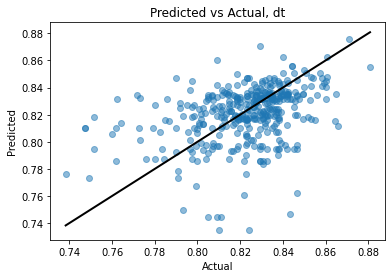

In [572]:
plt.scatter(x=y_test, y=dt_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, dt')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

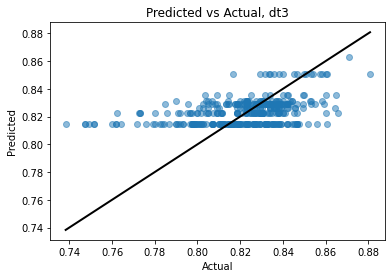

In [573]:
plt.scatter(x=y_test, y=dt3_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, dt3')
plt.xlabel('Actual')
plt.ylabel('Predicted')
#plt.savefig('dt3_predvactual.png')
#files.download("dt3_predvactual.png") 
plt.show()

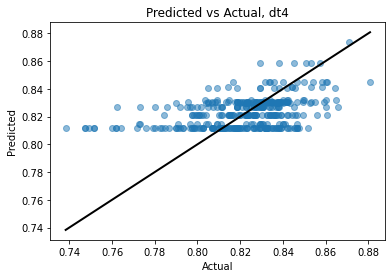

In [574]:
plt.scatter(x=y_test, y=dt4_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, dt4')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

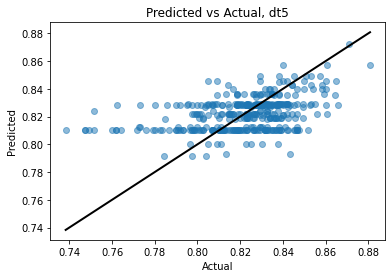

In [575]:
plt.scatter(x=y_test, y=dt5_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, dt5')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

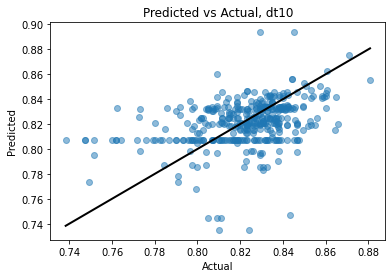

In [576]:
plt.scatter(x=y_test, y=dt10_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, dt10')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

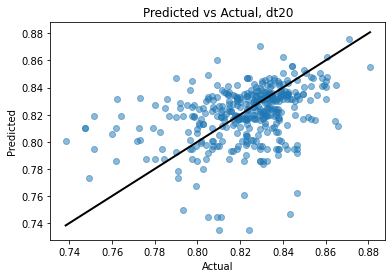

In [577]:
plt.scatter(x=y_test, y=dt20_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, dt20')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [578]:
depths = range(1,30,1)

In [579]:
my_rmse_stat = []
for depth in depths:
 my_rmse_stat.append(dt_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'rmse'))

In [580]:
my_mse_stat = []
for depth in depths:
 my_mse_stat.append(dt_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'mse'))

In [581]:
my_mae_stat = []
for depth in depths:
 my_mae_stat.append(dt_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'mae'))

In [582]:
my_mape_stat = []
for depth in depths:
 my_mape_stat.append(dt_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'mape'))

In [583]:
find_min_depth(my_rmse_stat, depths)

(3, 0.019656430104860612)

In [584]:
find_min_depth(my_mse_stat, depths)

(3, 0.00038637524446727065)

In [585]:
find_min_depth(my_mape_stat, depths)

(3, 0.018039470797265342)

In [586]:
find_min_depth(my_mae_stat, depths)

(3, 0.014658206978255263)

All error measures (RMSE, MSE, MAPE, MAE) minimized at max_depth = 3

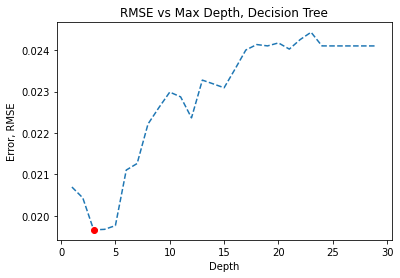

In [587]:
plt.plot(depths, my_rmse_stat, '--')
plt.plot(find_min_depth(my_rmse_stat, depths)[0], find_min_depth(my_rmse_stat, depths)[1], 'ro')
plt.title('RMSE vs Max Depth, Decision Tree')
plt.xlabel('Depth')
plt.ylabel('Error, RMSE')
plt.show()

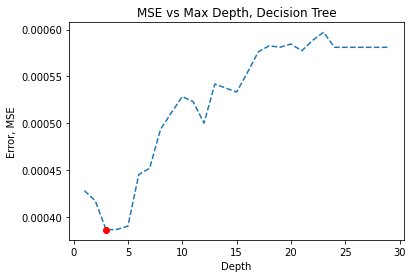

In [588]:
plt.plot(depths, my_mse_stat, '--')
plt.plot(find_min_depth(my_mse_stat, depths)[0], find_min_depth(my_mse_stat, depths)[1], 'ro')
plt.title('MSE vs Max Depth, Decision Tree')
plt.xlabel('Depth')
plt.ylabel('Error, MSE')
plt.show()

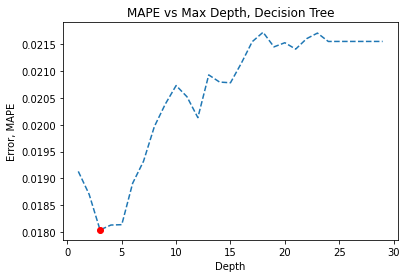

In [589]:
plt.plot(depths, my_mape_stat, '--')
plt.plot(find_min_depth(my_mape_stat, depths)[0], find_min_depth(my_mape_stat, depths)[1], 'ro')
plt.title('MAPE vs Max Depth, Decision Tree')
plt.xlabel('Depth')
plt.ylabel('Error, MAPE')
plt.show()

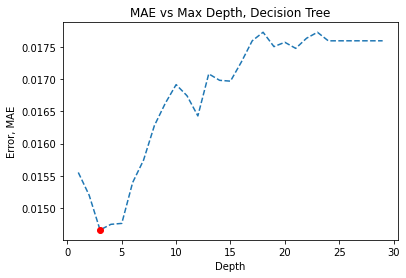

In [590]:
plt.plot(depths, my_mae_stat, '--')
plt.plot(find_min_depth(my_mae_stat, depths)[0], find_min_depth(my_mae_stat, depths)[1], 'ro')
plt.title('MAE vs Max Depth, Decision Tree')
plt.xlabel('Depth')
plt.ylabel('Error, MAE')
plt.show()

All four error measures (RMSE, MSE, MAPE, MAE) return similar error curves for different max_depths

In [591]:
params = {'max_depth':[1,2,3,4,5,10,20,25,30,50,100]}

dt = DecisionTreeRegressor(random_state=my_rand_state)

model = GridSearchCV(dt, params, cv=5)
model.fit(X_train, y_train)
model.best_params_

{'max_depth': 4}

GridSearchCV chooses `max_depth=4` to minimize errors

Choosing an algorithm with a max_depth of 3 or 4 minimizes all our error measures. However, I like how in the predictions vs actual plots, with an increase in max_depth, the algorithm learns more about low scoring coffees. One possible pitfall is not having enough data for low scoring coffees for the algorithm to learn those coffees well.  

### Random Forest

In [592]:
from sklearn.ensemble import RandomForestRegressor

In [593]:
rf4 = RandomForestRegressor(n_estimators = 1000, max_depth=4, random_state = my_rand_state)
rf5 = RandomForestRegressor(n_estimators = 1000, max_depth=5, random_state = my_rand_state)
rf10 = RandomForestRegressor(n_estimators = 1000, max_depth=10, random_state = my_rand_state)
rf20 = RandomForestRegressor(n_estimators = 1000, max_depth=20, random_state = my_rand_state)

rf4.fit(X_train, y_train)
rf5.fit(X_train, y_train)
rf10.fit(X_train, y_train)
rf20.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=1000, random_state=42)

In [594]:
rf4_predictions = rf4.predict(X_test)
rf5_predictions = rf5.predict(X_test)
rf10_predictions = rf10.predict(X_test)
rf20_predictions = rf20.predict(X_test)

rf4_score_train = rf4.score(X_train,y_train) ## to see if overfitting
rf5_score_train = rf5.score(X_train,y_train) ## to see if overfitting
rf10_score_train = rf10.score(X_train,y_train) ## to see if overfitting
rf20_score_train = rf20.score(X_train,y_train) ## to see if overfitting

rf4_score_test = rf4.score(X_test,y_test)   ## test
rf5_score_test = rf5.score(X_test,y_test)   ## test
rf10_score_test = rf10.score(X_test,y_test)   ## test
rf20_score_test = rf20.score(X_test,y_test)   ## test

#print('Accuracy of Decision Tree, train: {:.3f}'.format(rf_score_train))
print('Accuracy of Random Forest, maxdepth 4, test: {:.3f}'.format(rf4_score_test))
print('Accuracy of Random Forest, maxdepth 5, test: {:.3f}'.format(rf5_score_test))
print('Accuracy of Random Forest, maxdepth 10, test: {:.3f}'.format(rf10_score_test))
print('Accuracy of Random Forest, maxdepth 20, test: {:.3f}'.format(rf20_score_test))

Accuracy of Random Forest, maxdepth 4, test: 0.193
Accuracy of Random Forest, maxdepth 5, test: 0.193
Accuracy of Random Forest, maxdepth 10, test: 0.162
Accuracy of Random Forest, maxdepth 20, test: 0.085


In [595]:
rf4_scores = cross_val_score(rf4, X, y, cv=5)
rf5_scores = cross_val_score(rf5, X, y, cv=5)
rf10_scores = cross_val_score(rf10, X, y, cv=5)
rf20_scores = cross_val_score(rf20, X, y, cv=5)

print(rf4_scores)
print(rf4_scores.mean())

print(rf5_scores)
print(rf5_scores.mean())

print(rf10_scores)
print(rf10_scores.mean())

print(rf20_scores)
print(rf20_scores.mean())

[ -7.0952912  -28.0881499  -14.73614511  -9.59899888  -5.03190418]
-12.910097854052728
[ -7.01768259 -28.9206912  -16.46421694 -10.18275437  -4.97741407]
-13.512551834132552
[ -7.03181214 -33.67622387 -27.15268205 -14.63084551  -4.90287827]
-17.47888836801399
[ -7.04929883 -37.99915702 -38.85718441 -18.3812375   -4.91687293]
-21.440750138255318


In [596]:
test_stats(y_test, rf4_predictions)

rmse: 0.019408
mse: 0.000377
mape: 0.017864
mae: 0.014524


In [597]:
test_stats(y_test, rf5_predictions)

rmse: 0.019403
mse: 0.000376
mape: 0.017864
mae: 0.014532


In [598]:
test_stats(y_test, rf10_predictions)

rmse: 0.019775
mse: 0.000391
mape: 0.018298
mae: 0.014908


In [599]:
test_stats(y_test, rf20_predictions)

rmse: 0.020669
mse: 0.000427
mape: 0.018745
mae: 0.015280


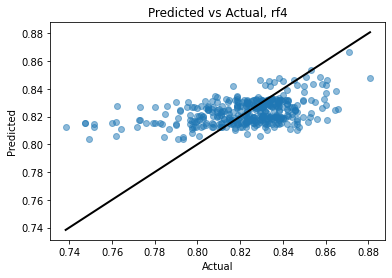

In [600]:
plt.scatter(x=y_test, y=rf4_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, rf4')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#plt.savefig('rf4_predvactual.png')
#files.download("rf4_predvactual.png") 

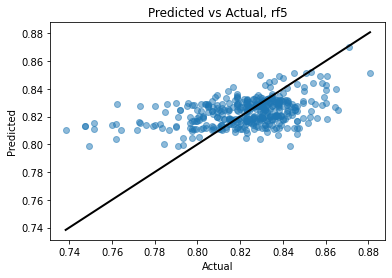

In [601]:
plt.scatter(x=y_test, y=rf5_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, rf5')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

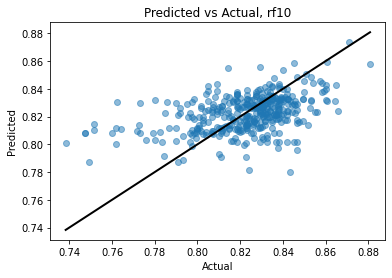

In [602]:
plt.scatter(x=y_test, y=rf10_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, rf10')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

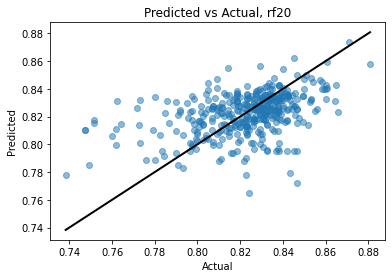

In [603]:
plt.scatter(x=y_test, y=rf20_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, rf20')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#plt.savefig('rf20_predvactual.png')
#files.download("rf20_predvactual.png") 

In [604]:
#depths = range(5,20,5)
depths = [1,2,3,4,5,10,20]

In [605]:
my_rmse_stat = []
for depth in depths:
 my_rmse_stat.append(rf_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'rmse'))

In [606]:
my_mse_stat = []
for depth in depths:
 my_mse_stat.append(rf_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'mse'))

In [607]:
my_mae_stat = []
for depth in depths:
 my_mae_stat.append(rf_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'mae'))

In [608]:
my_mape_stat = []
for depth in depths:
 my_mape_stat.append(rf_optimize_max_depth(X_test, y_test, X_train, y_train, depth, 'mape'))

In [609]:
find_min_depth(my_rmse_stat, depths)

(4, 0.019422054481096074)

In [610]:
find_min_depth(my_mse_stat, depths)

(4, 0.0003772162002666641)

In [611]:
find_min_depth(my_mape_stat, depths)

(4, 0.017879470312281605)

In [612]:
find_min_depth(my_mae_stat, depths)

(4, 0.014540069719962016)

All error measures (RMSE, MSE, MAPE, MAE) minimized at max_depth = 4

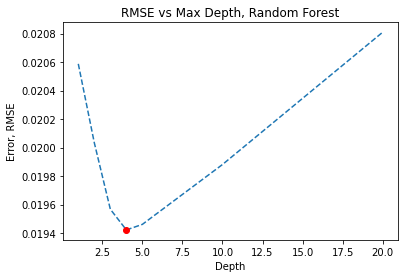

In [613]:
plt.plot(depths, my_rmse_stat, '--')
plt.plot(find_min_depth(my_rmse_stat, depths)[0], find_min_depth(my_rmse_stat, depths)[1], 'ro')
plt.title('RMSE vs Max Depth, Random Forest')
plt.xlabel('Depth')
plt.ylabel('Error, RMSE')
plt.show()

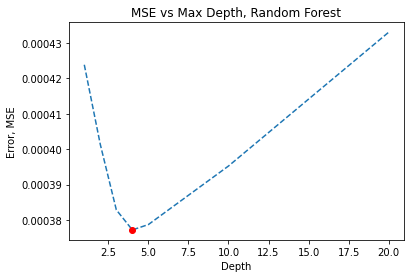

In [614]:
plt.plot(depths, my_mse_stat, '--')
plt.plot(find_min_depth(my_mse_stat, depths)[0], find_min_depth(my_mse_stat, depths)[1], 'ro')
plt.title('MSE vs Max Depth, Random Forest')
plt.xlabel('Depth')
plt.ylabel('Error, MSE')
plt.show()

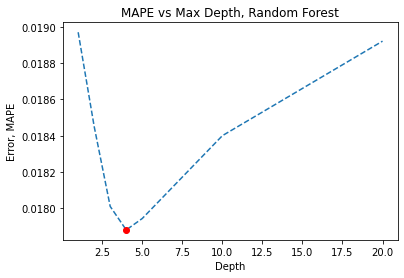

In [615]:
plt.plot(depths, my_mape_stat, '--')
plt.plot(find_min_depth(my_mape_stat, depths)[0], find_min_depth(my_mape_stat, depths)[1], 'ro')
plt.title('MAPE vs Max Depth, Random Forest')
plt.xlabel('Depth')
plt.ylabel('Error, MAPE')
plt.show()

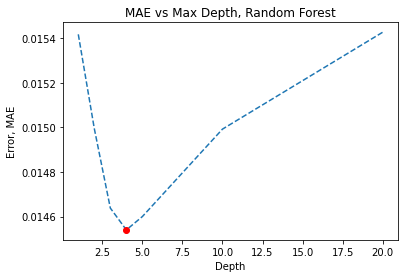

In [616]:
plt.plot(depths, my_mae_stat, '--')
plt.plot(find_min_depth(my_mae_stat, depths)[0], find_min_depth(my_mae_stat, depths)[1], 'ro')
plt.title('MAE vs Max Depth, Random Forest')
plt.xlabel('Depth')
plt.ylabel('Error, MAE')
plt.show()

All four error measures (RMSE, MSE, MAPE, MAE) return similar error curves for different max_depths

In [617]:
params = {'max_depth':[1,2,3,4,5,10,30]}

rf = RandomForestRegressor(random_state=my_rand_state)

model = GridSearchCV(dt, params, cv=5)
model.fit(X_train, y_train)
model.best_params_

{'max_depth': 4}

GridSearchCV also chooses `max_depth=4` to minimize errors

Again, Choosing an algorithm with a max_depth 4 minimizes all our error measures. However, I like how in the predictions vs actual plots, with an increase in max_depth, the algorithm learns more about low scoring coffees

### Support Vector

In [618]:
from sklearn.svm import SVR

In [619]:
svr = SVR(C=.1, gamma=.0001, max_iter=100, kernel='rbf')
svr.fit(X_train, y_train)

SVR(C=0.1, gamma=0.0001, max_iter=100)

In [620]:
svr_predictions = svr.predict(X_test)

svr_score_train = svr.score(X_train, y_train)
svr_score_test = svr.score(X_test, y_test)

print('Accuracy of SVR, train: {:.3f}'.format(svr_score_train))
print('Accuracy of SVR, test: {:.3f}'.format(svr_score_test))

Accuracy of SVR, train: -0.026
Accuracy of SVR, test: -0.015


In [621]:
svr_scores = cross_val_score(svr, X, y, cv=5)

print(svr_scores)
print(svr_scores.mean())

[-27.89765925 -25.85746374  -5.10119867  -1.61974923 -15.00657968]
-15.096530113700187


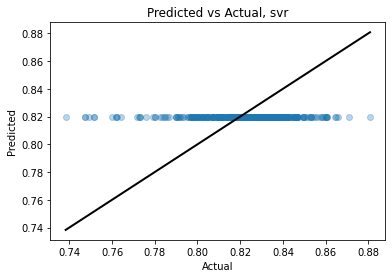

In [622]:
plt.scatter(x=y_test, y=svr_predictions, alpha=.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, svr')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#plt.savefig('svr_predvactual.png')
#files.download("svr_predvactual.png")

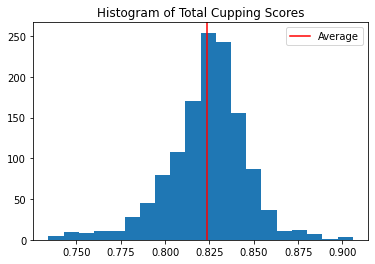

In [623]:
plt.hist(y, bins=20)
plt.title('Histogram of Total Cupping Scores')
plt.axvline(x=y.mean(), color='r')
plt.legend(['Average'])
plt.show()


With C=.1 and gamma=.0001, the support vector algorithm seems to predict a value close to the average of total cupping scores.

For Parameter Optimization:
```
0.0001 =< gamma =< 10
0.1 =< C =< 100
```

In [624]:
import numpy as np

In [625]:
gamma_params = np.linspace(.0001,10,10)  #np.linspace(start, stop, num)

In [626]:
C_params = np.linspace(.1,10,10)

In [627]:
params = {'gamma':gamma_params, 'C':C_params}

svr = SVR()
model = GridSearchCV(svr, params, cv=5)
model.fit(X_train, y_train)
model.best_params_

{'C': 0.1, 'gamma': 0.0001}

Parameters C and gamma are optimized at their minimum, C=0.1 and gamma=.0001

After parameter optimization, the Support Vector Algorithm still seems to predict a value similar to the mean of the target. This is not a very useful algorithm for this data set. I would ideally like a bigger data set to explore this further.

In [628]:
test_stats(y_test, svr_predictions)

rmse: 0.021760
mse: 0.000473
mape: 0.020506
mae: 0.016747


### OLS

In [629]:
from sklearn import linear_model
import statsmodels.api as sm

# You need to manually add a constant
# in statsmodels' sm
#X = sm.add_constant(X)

#results = sm.OLS(Y, X).fit()

#results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [630]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train,y_train)

LinearRegression()

In [631]:
lrm_predictions = lrm.predict(X_test)

lrm_score_train = lrm.score(X_train, y_train)
lrm_score_test = lrm.score(X_test, y_test)

print('Accuracy of lrm, train: {:.3f}'.format(lrm_score_train))
print('Accuracy of lrm, test: {:.3f}'.format(lrm_score_test))

Accuracy of lrm, train: 0.187
Accuracy of lrm, test: 0.146


In [632]:
lrm_scores = cross_val_score(lrm, X, y, cv=5)

print(lrm_scores)
print(lrm_scores.mean())

[ -6.64768205 -29.46373821 -17.53299755 -12.03917495  -4.9415114 ]
-14.125020832646868


In [633]:
test_stats(y_test, lrm_predictions)

rmse: 0.019964
mse: 0.000399
mape: 0.018777
mae: 0.015277


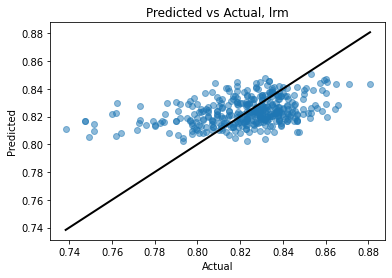

In [634]:
plt.scatter(x=y_test, y=lrm_predictions, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, lrm')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
#plt.savefig('lrm_predvactual.png')
#files.download("lrm_predvactual.png")

In [635]:
test_stats(y_test, lrm_predictions)

rmse: 0.019964
mse: 0.000399
mape: 0.018777
mae: 0.015277


In [636]:
pd.DataFrame(X.columns, columns=['features'])

,features
0,altitude
1,moisture
2,processing_method_Other/Semi
3,processing_method_Washed
4,region_Central America
5,region_East Africa
6,region_Islands
7,region_North America
8,region_South America
9,color_Bluish-Green


In [637]:
lrm_labeled_coef = pd.concat([pd.DataFrame(X.columns, columns=['features']), pd.DataFrame(lrm.coef_, columns=['coeficients'])], axis=1)

In [638]:
lrm_labeled_coef

,features,coeficients
0,altitude,0.020157
1,moisture,-0.030340
2,processing_method_Other/Semi,-0.001361
3,processing_method_Washed,-0.004855
4,region_Central America,0.001100
5,region_East Africa,0.015799
6,region_Islands,0.003394
7,region_North America,-0.001844
8,region_South America,0.006730
9,color_Bluish-Green,-0.000833


In [639]:
lrm_labeled_coef.sort_values('coeficients', ascending=False)

,features,coeficients
0,altitude,0.020157
5,region_East Africa,0.015799
8,region_South America,0.006730
6,region_Islands,0.003394
4,region_Central America,0.001100
9,color_Bluish-Green,-0.000833
2,processing_method_Other/Semi,-0.001361
7,region_North America,-0.001844
3,processing_method_Washed,-0.004855
10,color_Green,-0.005355


In [640]:
#transform back to [0,100] scale for total_cup_points 
(lrm_labeled_coef*100).sort_values('coeficients', ascending=False)

,features,coeficients
0,altitudealtitudealtitudealtitudealtitudealtitu...,2.015689
5,region_East Africaregion_East Africaregion_Eas...,1.579906
8,region_South Americaregion_South Americaregion...,0.673020
6,region_Islandsregion_Islandsregion_Islandsregi...,0.339394
4,region_Central Americaregion_Central Americare...,0.110043
9,color_Bluish-Greencolor_Bluish-Greencolor_Blui...,-0.083297
2,processing_method_Other/Semiprocessing_method_...,-0.136081
7,region_North Americaregion_North Americaregion...,-0.184439
3,processing_method_Washedprocessing_method_Wash...,-0.485494
10,color_Greencolor_Greencolor_Greencolor_Greenco...,-0.535485


In [641]:
df['processing_method'].unique()

array(['Washed / Wet', 'Natural / Dry', 'Pulped natural / honey',
       'Semi-washed / Semi-pulped', 'Other'], dtype=object)

Highest scoring process is natural

North America lowest scoring region -- makes sense with little of North America climate suitable for coffee growth

'Blue-Green' top scoring color

Top Important Features 
- Moisture (-3.03)
- Altitude (2.02)
- region_East Africa (1.58)
- region_South America (0.67)

baseline region = Asia

### KNN Regression


In [642]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [643]:
rmse_val = [] #to store rmse values for different k
for K in range(50):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.028140548436753034
RMSE value for k=  2 is: 0.02431810491555494
RMSE value for k=  3 is: 0.022730143896727062
RMSE value for k=  4 is: 0.021450374142237442
RMSE value for k=  5 is: 0.021066449051695166
RMSE value for k=  6 is: 0.02038932263581837
RMSE value for k=  7 is: 0.020292427215716963
RMSE value for k=  8 is: 0.02034173260195287
RMSE value for k=  9 is: 0.020227322074514636
RMSE value for k=  10 is: 0.01997892427747235
RMSE value for k=  11 is: 0.020041055445082924
RMSE value for k=  12 is: 0.019874444219426312
RMSE value for k=  13 is: 0.01987321329445343
RMSE value for k=  14 is: 0.019878373922142537
RMSE value for k=  15 is: 0.019807779572839995
RMSE value for k=  16 is: 0.019805815092745316
RMSE value for k=  17 is: 0.019765634489114323
RMSE value for k=  18 is: 0.019867526796912453
RMSE value for k=  19 is: 0.01989571793543179
RMSE value for k=  20 is: 0.019936821843518762
RMSE value for k=  21 is: 0.019626376104857377
RMSE value for k=  22 is: 0.

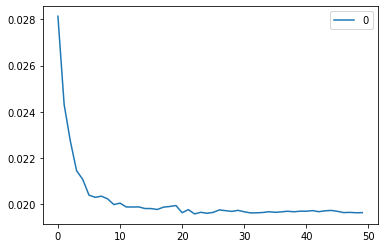

In [644]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [645]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
model.best_params_

{'n_neighbors': 17}

In [646]:
model = neighbors.KNeighborsRegressor(n_neighbors = 19)

In [647]:
#calculate RMSE
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set
error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
print(error)

0.01989571793543179


In [648]:
model = neighbors.KNeighborsRegressor(n_neighbors = 19, weights='distance')

In [649]:
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set
error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
print(error)

0.02132211785952224


higher rmse with `weight='distance'`

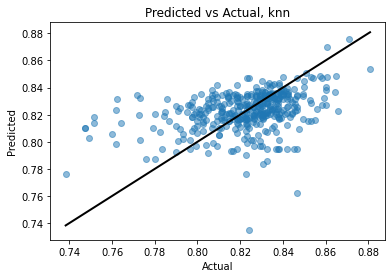

In [650]:
plt.scatter(x=y_test, y=pred, alpha=.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black', linewidth = 2)
plt.title('Predicted vs Actual, knn')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [651]:
test_stats(y_test, pred)

rmse: 0.021322
mse: 0.000455
mape: 0.019156
mae: 0.015608


## Model Selection

Based on minimizing error, the random forest model for a max depth of 4 performed the best. However, the OLS model has similar errors and is a simplier and more interpretable model. In this situation, I value interpretability as well as error minimization, so I would choose the OLS model

##Future Considerations

- Further EDA
  - Create new feature capturing the age of the coffee when cupped. 
    - `age` = `experation` - `grading_date`
    - Theory is that older coffee would have a lower cupping score than than fresher coffee
  - Create new features based on variety characteristics found at https://varieties.worldcoffeeresearch.org/varieties
   - potential features: bean size, quality potential at high_altitude, stature, yield potential
- More data for lower scoring coffees
- More features, particularly about roasting